# 0. Setup

In [1]:
! pip install transformers newspaper3k datasets urllib3==1.25.11

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 24.7 MB/s 
     |████████████████████████████████| 211 kB 94.1 MB/s 
     |████████████████████████████████| 452 kB 91.9 MB/s 
     |████████████████████████████████| 127 kB 65.9 MB/s 
     |████████████████████████████████| 182 kB 60.9 MB/s 
     |████████████████████████████████| 7.6 MB 39.9 MB/s 
     |████████████████████████████████| 81 kB 11.4 MB/s 
     |████████████████████████████████| 7.4 MB 55.3 MB/s 
     |████████████████████████████████| 93 kB 2.9 MB/s 
     |████████████████████████████████| 132 kB 65.5 MB/s 
     |████████████████████████████████| 212 kB 45.5 MB/s 
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13552 sha256=fd8d42303738f766b42a0bd893b8ace27ad05d0891935586dcb620b51b687211
  Stored in directory: /root/.cache/pip/wheels/99/74/83/8fac1c8d9c648cfabebbbffe97a889f6624817f3aa0bbe6c

In [2]:
import urllib3
import os
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Any
from tqdm import tqdm
import newspaper
from newspaper import Article
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
import datasets
from datasets.dataset_dict import DatasetDict
from datasets import Dataset
from datasets import load_dataset
import transformers
from transformers import pipeline
from transformers import TFAutoModel 
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import spacy

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
import spacy

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
MAIN_FOLDER = '/content/drive/MyDrive/url_classification/'
HTML_FOLDER = MAIN_FOLDER + 'html_files_Nov-24-2022/'
os.chdir(MAIN_FOLDER)

# 0.1 Defining variables

In [7]:
URL = 'url'
TARGET = 'label'
TEXT = 'text'

# Constants that will disappear when transitioning to functions:
# Cell 1

html_folder = HTML_FOLDER
# Cell 2

# Name of the file that will origin 'df_text1'
csv_path1 = 'activities_unlabeled.csv'
usecols1 = ['File Name', 'Label']

nlp = spacy.load('en_core_web_sm')

DISTILBERT_MAX_INPUT = 510 # 512 - the [CLS] and [SEP] tokens

In [8]:
# Name of the file that will origin 'df_text2'
csv_path = 'activities_labeled13.csv'
usecols = ['url', 'true_label']

In [9]:
# Cell 8

# Defining the classes that we are going to be working with and their encoded labels
labels_encoded = {'Article': 0, 'Blog': 1, 'Event': 2, 'Webinar': 3, 'PR': 4, 'MISC': 5}

labels_decoded = {y: x for x, y in labels_encoded.items()}
maximum_classes = len(labels_encoded)

In [10]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9A-Za-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [11]:
# Cell 9
test_size = 0.2
random_state = 0

# 0.2 Functions

## Saving/loading variables

In [12]:
def save_variable(variable, variable_name):
  """
  Saves a variable to be available for loading.
  @variable: name of the variable to save
  @variable_name: path of the variable saved
  """
  with open(f'./saved_variables/{variable_name}.pickle', 'wb') as f:
    pickle.dump(variable, f)

def read_variable(variable_name):
  """
  Loads a variable previously saved.
  @variable_name: path of the variable saved
  """
  with open(f'./saved_variables/{variable_name}.pickle', 'rb') as f:
    variable = pickle.load(f)
  return variable

def check_if_exists(variable_name):
  """
  Checks if a variable exists in the global scope.
  @variable_name: name of the variable
  """
  if variable_name in globals():
    print(f'Variable "{variable_name}" exists.')
  else:
    print(f'Variable "{variable_name}" does not exist.')

## Preprocessing

In [13]:
def get_most_common_tokens(df, column, amount=10):
  tokenized = [word_tokenize(string) for string in df[column]]
  flat_list = [item for sublist in tokenized for item in sublist]
  return Counter(flat_list).most_common(amount)

## Modeling

In [14]:
def fit_model(clf, X_train_transformed, y_train):
  clf.fit(X_train_transformed, y_train)
  return clf


def predict(clf, X_test_transformed):
  y_pred = clf.predict(X_test_transformed)
  return y_pred


def get_accuracy(y_test, y_pred):
  accuracy = sum(y_pred == y_test) / len(y_test)
  return accuracy


def print_important_features(clf, features=5):
  """ 
  Get the most important features of a classifier when using a linear kernel (e.g. Logistic Regression)
  """
  coef_importances = np.argsort(clf.coef_, axis=1)
  
  for i, class_ in enumerate(coef_importances[:, :features]):
      print(f'Class "{labels_decoded[clf.classes_[i]]}" - {features} most important features: '
            f'{vectorizer.get_feature_names_out()[class_]}')
      

def print_confusion_matrix(y_test, y_pred, with_report=False):

  accuracy = get_accuracy(y_test, y_pred)

  y_test = list(map(lambda x: labels_decoded[x], y_test))
  y_pred = list(map(lambda x: labels_decoded[x], y_pred))

  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plt.title(f'Confusion matrix - acc {accuracy:.3f}', size=15)
  plt.show()
  if with_report:
    print('\n' + classification_report(y_test, y_pred))


def get_best_clf(clfs, X_train, X_test, y_train, y_test):
    results = []
    best_clf = None
    best_clf_name = None
    best_accuracy = 0

    for clf_name, clf in clfs:
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test) # accuracy score
        
        if acc > best_accuracy:
            best_accuracy = acc
            best_clf = clf
            best_clf_name = clf_name

        results.append({'clf': clf_name,
                        'accuracy': acc})
        
    print(pd.DataFrame(results).set_index('clf'))
    return best_clf, best_clf_name, best_accuracy


def print_train_val_len_start(train_index, val_index):
    print(f'TRAIN index len: {len(train_index)}, start: {train_index[:3]}, '
          f'\tVALIDATION index len: {len(val_index)}, start: {val_index[:3]}')

def print_val_scores(scores, extra_info=False):
    print(f'Cross validation scores: mean: {np.mean(scores):.3f}, all: {[round(score, 3) for score in scores]}')
    if extra_info:
        print('(std: {np.std(scores):.3f}, min: {min(scores):.3f}, max: {max(scores):.3f})')


def create_misclassified_df(X_test, y_test, y_pred):
  if type(y_pred) == np.ndarray and type(y_test) == pd.core.series.Series:
    y_pred = pd.Series(y_pred, index=y_test.index) # setting y_pred to same type and indexes as y_test
  
  mask = y_pred != y_test
  
  if type(y_pred) == np.ndarray and type(y_test) == np.ndarray:
    y_pred = pd.Series(y_pred)
    y_test = pd.Series(y_test)
    
  df = X_test.copy()[mask]
  df['y_true'] = y_test[mask].replace(labels_decoded)
  df['y_pred'] = y_pred[mask].replace(labels_decoded) 
  return df
  

# 0.3 (Optional) Load "df_text1"

In [15]:
check_if_exists('df_text1')
df_text1 = read_variable('df_text1')
check_if_exists('df_text1')

Variable "df_text1" does not exist.
Variable "df_text1" exists.


In [16]:
df_text1

,text,label
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event
1,When Is ADA Compliance Legally Required?. The ...,White Paper
2,Write For Us. Want to Write for Us? Digital L...,MISC
3,"Write for Us. Yes, you. We’re always looking f...",MISC
4,FAQs for some new features available in the Be...,Blog
...,...,...
456,"The Art of SEO, 2nd Edition. Four acknowledged...",Product Page
457,Submit A Guest Post – Guidelines (Write for Us...,MISC
458,Fully Managed Magento Hosting — JetRails. Full...,MISC
459,Mission-Critical Hosting For Magento Open Sour...,MISC


# 0.4 (Optional) Load "df_text2"

In [17]:
VARIABLE = 'df_text2'

check_if_exists(VARIABLE)
print(f'Reading variable "{VARIABLE}"...')
df_text2 = read_variable(VARIABLE)
check_if_exists(VARIABLE)

Variable "df_text2" does not exist.
Reading variable "df_text2"...
Variable "df_text2" exists.


In [18]:
df_text2

,url,text,label
0,http://www.nctech.org/events/event/2021/awards...,NC TECH Awards Gala. #nctechawards Awards Gal...,Event
1,http://cdd-biologics.com/,Computational Drug Development for Biologics 2...,Event
2,http://sfesummit.com/,12th Annual Sales Force Effectiveness & Digita...,Event
3,http://www.obviohealth.com/events/informa-1-2021,ObvioHealth. MAGI Clinical Research Conference...,Webinar
4,http://www.genesisconference.com/,Home : Genesis 2022.,Event
...,...,...,...
1014,http://www.entrepreneur.com/article/400416,Veeva Systems is a Top Stock for 2022. Veeva S...,Article
1015,http://www.koreabiomed.com/news/articleView.ht...,Medidata’s Acorn AI solution raises clinical t...,Article
1016,http://www.finsmes.com/2021/10/science-37-clos...,Science 37 Closes Business Combination with Li...,?
1017,http://seekingalpha.com/article/4450420-labora...,Laboratory Corp: 18%-20% Yearly Return With Sa...,-


# 0.5 (Optional) Load "df_text"

In [19]:
VARIABLE = 'df_text'

check_if_exists(VARIABLE)
print(f'Reading variable "{VARIABLE}"...')
df_text = read_variable(VARIABLE)
check_if_exists(VARIABLE)

Variable "df_text" does not exist.
Reading variable "df_text"...
Variable "df_text" exists.


In [20]:
df_text

,text,label,url,lemmatized_text,lemmatized_cleaned_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event,NaN,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...
1,Write For Us. Want to Write for Us? Digital L...,MISC,NaN,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...
2,"Write for Us. Yes, you. We’re always looking f...",MISC,NaN,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...
3,FAQs for some new features available in the Be...,Blog,NaN,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...
4,The Best Nootropic Stack to Replace Adderall &...,Article,NaN,the Best Nootropic Stack to replace Adderall &...,Best Nootropic Stack replace Adderall Ritalin ...
...,...,...,...,...,...
959,Veeva Systems Korea aims to become cloud SW le...,Article,http://www.koreabiomed.com/news/articleView.ht...,Veeva Systems Korea aim to become cloud SW lea...,Veeva Systems Korea aim become cloud SW leader...
960,Digital transformation of clinical research ac...,Article,http://www.outsourcing-pharma.com/Article/2021...,digital transformation of clinical research ac...,digital transformation clinical research accel...
961,Veeva Systems is a Top Stock for 2022. Veeva S...,Article,http://www.entrepreneur.com/article/400416,Veeva Systems be a Top Stock for 2022 . Veeva ...,Veeva Systems Top Stock 2022 Veeva Systems VEE...
962,Medidata’s Acorn AI solution raises clinical t...,Article,http://www.koreabiomed.com/news/articleView.ht...,Medidata ’s Acorn AI solution raise clinical t...,Medidata Acorn AI solution raise clinical tria...


# 0.6 (Optional) Create and save "df_text1" - general preprocessing of html

In [21]:
def create_df(csv_path: str, usecols: List[str], namecols: List[str] = None, remove_nan: str = None, ignore_dash: bool = False) -> pd.DataFrame:
  """
  Create a DataFrame from a CSV file.

  @csv_path (str): the path to the CSV file.
  @usecols (List[str]): a list of column names to use from the CSV file. If not provided, all columns will be used.
  @namecols (List[str]): a list of new names for the columns from the CSV file. If not provided, the original column names will be used.
  @remove_nan (str): the name of the column from where rows with missing values will be removed. It must be from namecols (or from usecols, if namecols was not provided). If not provided, all rows will be kept.
  @ignore_dash (bool): a flag indicating whether to ignore rows with a dash (`-`) in the target column. If not provided, rows with a dash in the target column will be included in the data.

  Returns: a pandas DataFrame object.
  """

  df = pd.read_csv(csv_path, usecols=usecols)

  if namecols:
    assert len(usecols) == len(namecols)
    rename_columns = {usecols[i]: namecols[i] for i in range(len(usecols))}
    df.rename(columns=rename_columns, inplace=True)
  
  if remove_nan:
    df = df[~df[remove_nan].isna()]

  if ignore_dash:
    df = df[df['label'] != '-']
  
  df.loc[df[TARGET] == 'MISC/Blog?', TARGET] = 'MISC' # all sections of blogs labeled as 'MISC/Blog?' become part of 'MISC'.

  df.reset_index(drop=True, inplace=True)

  return df

In [22]:
HTML_FOLDER = MAIN_FOLDER + 'html_files_Nov-24-2022/'

def read_htmls(df: pd.DataFrame, column: str) -> List[str]:
  """
  Read HTML files from a pandas DataFrame.

  @df (pd.DataFrame): a DataFrame with a column containing the names of the HTML files.
  @column (str): the name of the column in the DataFrame where the filenames are stored.

  Returns: a list of strings, one for each HTML file.
  """

  filenames = df[column].values
  htmls = list()

  for i, filename in enumerate(tqdm(filenames)):
    try:
      with open(f'{HTML_FOLDER}{filename}') as f:
        html = f.read()
        htmls.append(html)
    except FileNotFoundError:
      print(f'File {i} not found: "{filename}"')
  
  return htmls

In [23]:
def read_articles(htmls: List[str]) -> List[newspaper.article.Article]:
  """
  Read articles from a list of HTML strings.
  
  @htmls (List[str]): a list of HTML strings representing articles.
  
  Returns: a list of newspaper.article.Article objects, one for each HTML string.
  """
  toi_articles = list()

  for html in tqdm(htmls):
    toi_article = Article(url = ' ', language = 'en')
    toi_article.set_html(html)
    toi_article.parse()
    toi_article.nlp()
    toi_articles.append(toi_article)

  return toi_articles

In [24]:
def create_df_text1(df: pd.DataFrame, toi_articles: List[newspaper.article.Article]) -> pd.DataFrame:
  """
  Create a DataFrame with article text and labels from a list of articles.
  
  @df (pd.DataFrame): a DataFrame with a TARGET column containing the labels for the articles.
  @toi_articles (List[newspaper.article.Article]): a list of newspaper.article.Article objects.
  
  Returns: a DataFrame with two columns: TEXT, containing the concatenated title and text of the articles, and TARGET, containing the labels for the articles.
  """

  summaries = [(toi_article.title + '. ' + toi_article.text).replace('\n', ' ') for toi_article in toi_articles]
  y = df[TARGET].tolist()
  assert len(y) == len(summaries)

  df_text1 = pd.DataFrame({TEXT: summaries, TARGET: y})

  return df_text1

In [ ]:
html_files = os.listdir(html_folder) # This is not needed actually I think and can be deleted

In [157]:
df1 = create_df('activities_unlabeled.csv', usecols=['File Name', 'Label'], namecols=['filename', 'label'], remove_nan='filename', ignore_dash=True)
htmls = read_htmls(df1, 'filename')
toi_articles = read_articles(htmls)
df_text1 = create_df_text1(df1, toi_articles)

100%|██████████| 461/461 [01:24<00:00,  5.48it/s]


In [ ]:
save_variable(df_text1, 'df_text1')

# 0.7 (Optional) Create and save "df_text2" - general preprocessing of urls

In [26]:
def read_or_create_variables(variable_names: List[str]) -> List[Any]:
  """
  Read or create variables with the given names. If a variable exists, it is read and returned. 
  If a variable with a given name does not exist, it is created and an empty list is returned.
  
  @variable_names: list of strings representing the names of the variables to be read and/or created.
  
  Returns a list of the read and/or created variables.
  """

  variables = list()

  for variable_name in variable_names:
    try:
      variable = read_variable(variable_name)
      print(f'SUCCESS: variable {variable_name} was read, it contains {len(variable)} elements.')
    except FileNotFoundError:
      variable = list()
      print(f'Variable {variable_name} was just created and contains {len(variable)} elements.')

    variables.append(variable)

  return variables

In [28]:
def create_urls_to_read(df: pd.DataFrame, column: str) -> pd.Series:
  """
  Creates the urls to read based on the difference between all URLs and the ones already read.

  @df (pd.DataFrame): a DataFrame with a column containing the URLs.
  @column (str): the name of the column in the DataFrame where the URLs are stored.

  Returns a pandas Series object with strings of the URLs to read.
  """

  urls = df[column]
  mask = np.isin(urls, urls_old)
  urls_new = urls[~mask]
  print(f'There are {len(urls_new)} new URLs to read.')

  return urls_new

In [30]:
def read_texts_from_urls(urls_new: pd.Series, urls_old: List[str]) -> Tuple[List[str], List[int], List[int]]:
  """
  Reads the relevant text from each URL.

  @urls_new: pandas Series object with strings of the URLs to read.
  @urls_old: list of strings of the URLs that have already been read.
  
  Returns a tuple of three elements:
  - texts_new: list of strings of the texts read from the URLs.
  - indexes_new: list of integers representing the indexes of the URLs that were read successfully.
  - idx_label_to_remove: list of integers representing the indexes, starting from 0, that threw errors and should be deleted.
  """

  texts_new = list()
  indexes_new = list()

  idx_label_to_remove = list()
  idx_label = 0

  for i, url in enumerate(urls_new, len(urls_old)):
    try:
      toi_article = Article(url=url, language='en')
      toi_article.download()
      toi_article.parse()
      toi_article.nlp()
      text = (toi_article.title + '. ' + toi_article.text).replace('\n', ' ')
      texts_new.append(text)
      indexes_new.append(i)
      print(f'{i}: url "{url}" read successfully.')
    except Exception:
      idx_label_to_remove.append(idx_label)
      print(f'{i}: ERROR: url "{url}" was not read successfully.')
    
    idx_label += 1
  
  if idx_label_to_remove:
    print(f'\nWhen reading the new URLs, {len(urls_new) - len(indexes_new)} of them threw an error and could not be read.')
  elif texts_new:
    print('All URLs were successfully read.')
  else:
    print('No new URL was read.')

  return texts_new, indexes_new, idx_label_to_remove

In [32]:
def create_new_labels(df: pd.DataFrame, urls_to_read: pd.Series, idx_label_to_remove: List[int]) -> List[str]:
  """
  Creates a list of labels for the given URLs and removes the labels corresponding to the URLs that threw errors.
  
  @df: pandas DataFrame containing the labels.
  @urls_to_read: pandas Series object with strings of the URLs for which the labels should be created.
  @idx_label_to_remove: list of integers representing the indexes of the URLs that threw errors and should have their labels removed.
  
  Returns:
  - labels_new: list of labels according to the new URLs, discarding the ones that threw errors.
  """
  
  labels_new = df.loc[urls_to_read.index, TARGET]
  assert (labels_new == df.loc[labels_new.index, TARGET]).all()
  labels_new.reset_index(drop=True, inplace=True)
  labels_new = labels_new.drop(idx_label_to_remove).tolist()

  return labels_new

In [43]:
def update_variables(old_variables: List[Any], new_variables: List[Any]) -> List[Any]:
  """
  Updates the old variables with the new variables.
  
  @old_variables: list of variables that should be updated.
  @new_variables: list of variables used to update the old variables, should be of same length and order as `old_variables`.
  
  Returns:
  - updated_variables: list of variables that are the result of updating the old variables with the new variables.
  """

  assert len(old_variables) == len(new_variables)

  updated_variables = list()
  zipped_variables = list(zip(old_variables, new_variables))

  for old_var, new_var in zipped_variables:
    updated_variable = old_var + new_var
    updated_variables.append(updated_variable)

  return updated_variables

In [ ]:
# labels = labels_old + labels_new
# indexes = indexes_old + indexes_new
# texts = texts_old + texts_new

# # We change the type and order of urls, deleting also the ones repeated in 'urls_old' and 'urls_new'
# urls = urls_old + urls_new.tolist()

# assert len(texts) == len(pd.Series(urls).loc[indexes]) == len(indexes) == len(labels)

In [ ]:
def create_df_text1(df: pd.DataFrame, toi_articles: List[newspaper.article.Article]) -> pd.DataFrame:
  """
  Create a DataFrame with article text and labels from a list of articles.
  
  @df (pd.DataFrame): a DataFrame with a TARGET column containing the labels for the articles.
  @toi_articles (List[newspaper.article.Article]): a list of newspaper.article.Article objects.
  
  Returns: a DataFrame with two columns: TEXT, containing the concatenated title and text of the articles, and TARGET, containing the labels for the articles.
  """

  summaries = [(toi_article.title + '. ' + toi_article.text).replace('\n', ' ') for toi_article in toi_articles]
  y = df[TARGET].tolist()
  assert len(y) == len(summaries)

  df_text1 = pd.DataFrame({TEXT: summaries, TARGET: y})

  return df_text1

In [45]:
def create_df_text2(labels: List[str], indexes: List[int], texts: List[str], urls: List[str]) -> pd.DataFrame:
  """
  Creates a pandas DataFrame with columns for URLs, texts, and labels.
  
  @labels: list of strings representing the labels of the articles.
  @indexes: list of integers representing the indexes of the articles.
  @texts: list of strings representing the texts of the articles.
  @urls: list of strings representing the URLs of the articles.
  
  Returns:
  - df_text2: pandas DataFrame with columns for URLs, texts, and labels.
  """

  df_text2 = pd.DataFrame({
      URL: pd.Series(urls).loc[indexes],
      TEXT: texts,
      TARGET: labels,
      }).reset_index(drop=True)

  return df_text2

In [ ]:
# df_text2 = pd.DataFrame({
#     URL: pd.Series(urls).loc[indexes],
#     TEXT: texts,
#     TARGET: labels,
#     }).reset_index(drop=True)

In [50]:
df_data = create_df('activities_labeled13.csv', usecols=['url', 'true_label'], namecols=['url', 'label'], remove_nan='label')
labels_old, indexes_old, texts_old, urls_old = read_or_create_variables(['labels_old', 'indexes_old', 'texts_old', 'urls_old'])
urls_new = create_urls_to_read(df_data, 'url')
texts_new, indexes_new, idx_label_to_remove = read_texts_from_urls(urls_new, urls_old)
labels_new = create_new_labels(df_data, urls_new, idx_label_to_remove)
labels, indexes, texts, urls = update_variables(old_variables=[labels_old, indexes_old, texts_old, urls_old],
                                                new_variables=[labels_new, indexes_new, texts_new, urls_new.tolist()])
assert len(texts) == len(pd.Series(urls).loc[indexes]) == len(indexes) == len(labels)
df_text2 = create_df_text2(labels, indexes, texts, urls)

SUCCESS: variable labels_old was read, it contains 1019 elements.
SUCCESS: variable indexes_old was read, it contains 1019 elements.
SUCCESS: variable texts_old was read, it contains 1019 elements.
SUCCESS: variable urls_old was read, it contains 1246 elements.
There are 0 new URLs to read.
No new URL was read.


In [ ]:
save_variable(labels, 'labels_old')
save_variable(indexes, 'indexes_old')
save_variable(texts, 'texts_old')
save_variable(urls, 'urls_old')
save_variable(df_text2, 'df_text2')

# 0.8 (Optional) Create and save "df_text"

In [18]:
if df_text2[URL].duplicated().sum() == 0:
  print(f'There are no duplicate URLs or texts in df_text2.')
else:
  original_amount = df_text2.shape[0]
  df_text2 = df_text2[~df_text2[URL].duplicated()]
  print(f"{original_amount - df_text2.shape[0]} URLs were duplicates and hence deleted.")
  assert df_text2[URL].duplicated().sum() == 0

69 URLs were duplicates and hence deleted.


In [19]:
df_text = pd.concat([df_text1, df_text2]).reset_index(drop=True)

In [20]:
if df_text[TEXT].duplicated().sum() == 0:
  print(f'There are no duplicate URLs or texts in df_text.')
else:
  original_amount = df_text.shape[0]
  df_text = df_text[~df_text[TEXT].duplicated()]
  print(f"{original_amount - df_text.shape[0]} texts were duplicates and hence deleted.")
  assert df_text[TEXT].duplicated().sum() == 0

59 texts were duplicates and hence deleted.


In [21]:
# import seaborn as sns
# values = df_text['text'].str.split().str.len()
# sns.boxplot(x=values)
# plt.show()

In [22]:
df_text.shape

(1352, 3)

In [23]:
# Filtering out all texts with strings ' 404 ' and ' error ' than contain less than 100 words.
characters = df_text[TEXT].str.split().str.len()
condition = (df_text[TEXT].str.contains(' 404 ')) & (df_text[TEXT].str.contains(' error ')) & (characters < 100)
df_text = df_text[~condition]

In [24]:
df_text.shape

(1351, 3)

In [25]:
# To play with:

# THRESHOLD1 = 50
# THRESHOLD2 = 51

# characters = df_text[TEXT].str.split().str.len()
# df_text.loc[(characters >= THRESHOLD1) & (characters <= THRESHOLD2), TEXT].tolist()

In [26]:
# By analizing the texts, errors started to show up in the ones that had below 51 words.

fraction_ignored = 0.165 # We will lose 16.5% of our data

values = df_text['text'].str.split().str.len()
minimum_words = values.quantile(fraction_ignored)
minimum_words

51.0

In [27]:
values.describe()[['25%', '75%']]

25%     80.0
75%    593.0
Name: text, dtype: float64

In [28]:
df_text[TARGET].value_counts().head(7)

Webinar      208
Event        206
Blog         202
Home Page    196
PR           151
MISC         110
Article       87
Name: label, dtype: int64

In [29]:
df_text.shape

(1351, 3)

In [30]:
if maximum_classes:
  df_text = df_text[df_text[TARGET].isin(labels_encoded)]

df_text.reset_index(drop=True, inplace=True)

In [31]:
df_text.shape

(964, 3)

In [32]:
# Important cell # 8

# If the text a URL contains is below this threshold, it gets discarded
minimum_words = 51

if minimum_words:
  df_text = df_text[df_text[TEXT].str.split().str.len() >= minimum_words]

In [33]:
df_text.shape

(857, 3)

In [34]:
mask = df_text[TEXT].str.split().str.len() > DISTILBERT_MAX_INPUT
print(f'There are {mask.sum()} texts ({mask.sum() / df_text.shape[0]:.0%} of the total) that will be truncated by DistilBERT '
      f'for having more than {DISTILBERT_MAX_INPUT} words.')

There are 364 texts (42% of the total) that will be truncated by DistilBERT for having more than 512 words.


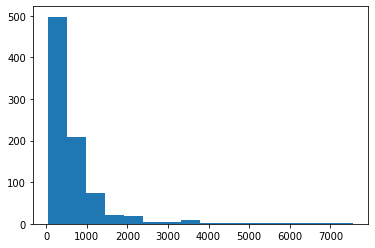

In [35]:
plt.hist(df_text[TEXT].str.split().str.len(), bins=16)
plt.show()

In [36]:
# df_text.loc[df_text[TEXT].str.split().str.len() > DISTILBERT_MAX_INPUT, TEXT].str.split().str.len()

In [37]:
df_text.shape[0]

857

In [38]:
df_text[TARGET].value_counts()

Blog       198
Event      174
Webinar    172
PR         150
Article     86
MISC        77
Name: label, dtype: int64

In [39]:
# Important cell # 8
def clean_text(text):
    """
    @text: a string
    Returns a cleaned version of the initial string
    """
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replaces REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # deletes symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # deletes stopwords from text
    return text

# print(f"Amount of words before cleaning text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")
# print(f"Amount of unique words before cleaning text: {np.unique(np.concatenate(df_text[TEXT].str.split().values, axis=0)).shape[0]}\n")
# df_text['cleaned_text'] = df_text[TEXT].apply(clean_text)
# print(f"Amount of words after cleaning text: {df_text['cleaned_text'].apply(lambda x: len(x.split(' '))).sum()}")
# print(f"Amount of unique words before cleaning text: {np.unique(np.concatenate(df_text['cleaned_text'].str.split().values, axis=0)).shape[0]}")

In [40]:
def lemmatize_text(text):
    """
    @text: a string
    Returns a lemmatized version of the initial string
    """
    lemmatized = ' '.join(token.lemma_ for token in nlp(text))
    return lemmatized

print(f"Amount of words before lemmatizing text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before lemmatizing text: {np.unique(np.concatenate(df_text[TEXT].str.split().values, axis=0)).shape[0]}\n")
df_text['lemmatized_text'] = df_text[TEXT].apply(lemmatize_text)
print(f"Amount of words after lemmatizing text: {df_text['lemmatized_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before lemmatizing text: {np.unique(np.concatenate(df_text['lemmatized_text'].str.split().values, axis=0)).shape[0]}")

Amount of words before lemmatizing text: 588737
Amount of unique words before lemmatizing text: 50526

Amount of words after lemmatizing text: 707420
Amount of unique words before lemmatizing text: 23242


In [41]:
print(f"Amount of words before cleaning lemmatized text: {df_text['lemmatized_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning lemmatized text: {np.unique(np.concatenate(df_text['lemmatized_text'].str.split().values, axis=0)).shape[0]}\n")
df_text['lemmatized_cleaned_text'] = df_text['lemmatized_text'].apply(clean_text)
print(f"Amount of words after cleaning lemmatized text: {df_text['lemmatized_cleaned_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning lemmatized text: {np.unique(np.concatenate(df_text['lemmatized_cleaned_text'].str.split().values, axis=0)).shape[0]}")

Amount of words before cleaning lemmatized text: 707420
Amount of unique words before cleaning lemmatized text: 23242

Amount of words after cleaning lemmatized text: 351888
Amount of unique words before cleaning lemmatized text: 21922


In [42]:
df_text.head(3) # df with different techniques for preprocessing of the text

,text,label,url,lemmatized_text,lemmatized_cleaned_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event,NaN,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...
1,Write For Us. Want to Write for Us? Digital L...,MISC,NaN,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...
2,"Write for Us. Yes, you. We’re always looking f...",MISC,NaN,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...


In [43]:
# def lemmatize_text2(text):
#   lemmatized = ' '.join(token.text.lower() for token in nlp(text))
#   return lemmatized

# df_text['w2v_text'] = df_text[TEXT].apply(lemmatize_text2)

In [44]:
save_variable(df_text, 'df_text')

In [45]:
# df_text = read_variable('df_text')

In [47]:
df_text

,text,label,url,lemmatized_text,lemmatized_cleaned_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event,NaN,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...
1,Write For Us. Want to Write for Us? Digital L...,MISC,NaN,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...
2,"Write for Us. Yes, you. We’re always looking f...",MISC,NaN,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...
3,FAQs for some new features available in the Be...,Blog,NaN,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...
4,The Best Nootropic Stack to Replace Adderall &...,Article,NaN,the Best Nootropic Stack to replace Adderall &...,Best Nootropic Stack replace Adderall Ritalin ...
...,...,...,...,...,...
959,Veeva Systems Korea aims to become cloud SW le...,Article,http://www.koreabiomed.com/news/articleView.ht...,Veeva Systems Korea aim to become cloud SW lea...,Veeva Systems Korea aim become cloud SW leader...
960,Digital transformation of clinical research ac...,Article,http://www.outsourcing-pharma.com/Article/2021...,digital transformation of clinical research ac...,digital transformation clinical research accel...
961,Veeva Systems is a Top Stock for 2022. Veeva S...,Article,http://www.entrepreneur.com/article/400416,Veeva Systems be a Top Stock for 2022 . Veeva ...,Veeva Systems Top Stock 2022 Veeva Systems VEE...
962,Medidata’s Acorn AI solution raises clinical t...,Article,http://www.koreabiomed.com/news/articleView.ht...,Medidata ’s Acorn AI solution raise clinical t...,Medidata Acorn AI solution raise clinical tria...


# 0.9 Further EDA and preprocessing on "df_text"

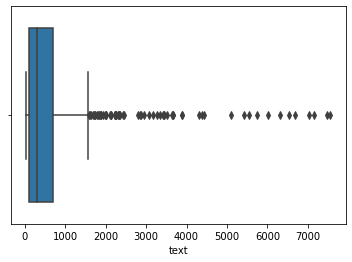

In [ ]:
import seaborn as sns
values = df_text['text'].str.split().str.len()
sns.boxplot(x=values)
plt.show()

values = df_text['text'].str.split().str.len()
minimum_words = values.quantile(0.15) # we ignore 15 % of the data, making sure the threshold ignores all outliers (< 0.25)
minimum_words

values.describe()[['25%', '75%']]

In [ ]:
values = df_text['text'].str.split().str.len()
minimum_words = values.quantile(0.15) # we ignore 15 % of the data, making sure the threshold ignores all outliers (< 0.25)
minimum_words

72.0

In [ ]:
values.describe()[['25%', '75%']]

25%    110.5
75%    697.5
Name: text, dtype: float64

In [ ]:
# df_text[TARGET].replace({1: 5}, inplace=True) # make Blog and Article a single category

In [ ]:
df_text[TARGET].value_counts()

5    176
0    128
7    124
6     85
2     79
4     55
3     44
Name: label, dtype: int64

In [ ]:
labels_encoded

{'Home Page': 0,
 'Blog': 1,
 'MISC': 2,
 'Product Page': 3,
 'Event': 4,
 'Article': 5,
 'Webinar': 6,
 'PR': 7}

# 1. BoW approach

## Preprocessing

In [21]:
labels_encoded

{'Article': 0, 'Blog': 1, 'Event': 2, 'Webinar': 3, 'PR': 4, 'MISC': 5}

In [22]:
df_text[TARGET] = df_text[TARGET].replace(labels_encoded)

In [23]:
df_text[TARGET].value_counts()

1    198
2    174
3    172
4    150
0     86
5     77
Name: label, dtype: int64

In [24]:
# Important cell # 9
column_used = 'lemmatized_cleaned_text'

X = df_text[[column_used]]
y = df_text[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state
                                                    )

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((685, 1), (172, 1), (685,), (172,))

In [42]:
# Making sure the split was stratified correctly.
train_distribution = y_train.value_counts(normalize=True)
test_distribution = y_test.value_counts(normalize=True)
assert (np.isclose(train_distribution, test_distribution, rtol=1e-01)).all()

In [43]:
# Important cell # 10
majority_class = y_train.value_counts().index[0]
baseline_accuracy = sum(y_test == majority_class) / len(y_test)
print(f'Baseline accuracy when predicting always the majority class: {baseline_accuracy:.4f}')

Baseline accuracy when predicting always the majority class: 0.2326


In [44]:
get_most_common_tokens(df=X_train, column='lemmatized_cleaned_text', amount=10)

[('use', 1690),
 ('patient', 1572),
 ('clinical', 1394),
 ('trial', 1351),
 ('datum', 1345),
 ('company', 1241),
 ('I', 1232),
 ('make', 1187),
 ('content', 1174),
 ('post', 1077)]

In [48]:
# Important cell # 11
ngram_range=(1, 3)

vectorizer = TfidfVectorizer(ngram_range=ngram_range)
X_train_tr = vectorizer.fit_transform(X_train[column_used])
X_test_tr = vectorizer.transform(X_test[column_used])

In [49]:
X_train_tr.toarray().shape, X_test_tr.toarray().shape

((685, 440643), (172, 440643))

## Modeling

In [65]:
clfs = [
    ('LogisticRegression', LogisticRegression(max_iter=3000,
                                              class_weight='balanced')), 
    ('RandomForest', RandomForestClassifier(max_depth=18,
                                            n_estimators=75,
                                            random_state=0)), 
    ('KNN 5', KNeighborsClassifier(n_neighbors=5)),
    ('SVM C1', SVC(C=1, 
                   class_weight='balanced')),
    ('MultinomialNB', MultinomialNB())
]

In [66]:
for clf in clfs:
  print(f'\nStratifiedKFold - classifier: {clf[0]}:\n')
  skf = StratifiedKFold(n_splits=5)
  for train_index, val_index in skf.split(X_train_tr, y_train):
      print_train_val_len_start(train_index, val_index)
      print(f'\tMean y: TRAIN: {y_train.iloc[train_index].mean():.3f},\tVALIDATION: {y_train.iloc[val_index].mean():.3f}')

  scores = cross_val_score(clf[1], 
                          X_train_tr,
                          y_train,
                          cv=5)
  
  print_val_scores(scores)


StratifiedKFold - classifier: LogisticRegression:

TRAIN index len: 548, start: [121 122 125], 	VALIDATION index len: 137, start: [0 1 2]
	Mean y: TRAIN: 2.389,	VALIDATION: 2.394
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index len: 137, start: [121 122 125]
	Mean y: TRAIN: 2.394,	VALIDATION: 2.372
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index len: 137, start: [255 258 260]
	Mean y: TRAIN: 2.387,	VALIDATION: 2.401
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index len: 137, start: [364 370 371]
	Mean y: TRAIN: 2.387,	VALIDATION: 2.401
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index len: 137, start: [481 498 512]
	Mean y: TRAIN: 2.392,	VALIDATION: 2.380
Cross validation scores: mean: 0.780, all: [0.723, 0.788, 0.818, 0.73, 0.839]

StratifiedKFold - classifier: RandomForest:

TRAIN index len: 548, start: [121 122 125], 	VALIDATION index len: 137, start: [0 1 2]
	Mean y: TRAIN: 2.389,	VALIDATION: 2.394
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index 

Checking results on the test set:

In [ ]:
def get_best_clf(clfs, X_train, X_test, y_train, y_test):
    results = []
    best_clf = None
    best_clf_name = None
    best_accuracy = 0

    for clf_name, clf in clfs:
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test) # accuracy score
        
        if acc > best_accuracy:
            best_accuracy = acc
            best_clf = clf
            best_clf_name = clf_name

        results.append({'clf': clf_name,
                        'accuracy': acc})
        
    print(pd.DataFrame(results).set_index('clf'))
    return best_clf, best_clf_name, best_accuracy

In [69]:
# clf, clf_name, val_acc = get_best_clf(clfs, X_train, X_test, y_train, y_test)
# print(f'Best classifier: {clf_name}, validation accuracy: {val_acc:.3f}, '
#       f'test accuracy: {clf.score(X_test, y_test):.3f}')

clf, clf_name, test_acc = get_best_clf(clfs, X_train_tr, X_test_tr, y_train, y_test)
print(f'Best classifier: {clf_name}, test accuracy: {test_acc:.3f}')

                    accuracy
clf                         
LogisticRegression  0.790698
RandomForest        0.750000
KNN 5               0.668605
SVM C1              0.761628
MultinomialNB       0.616279
Best classifier: LogisticRegression, test accuracy: 0.791


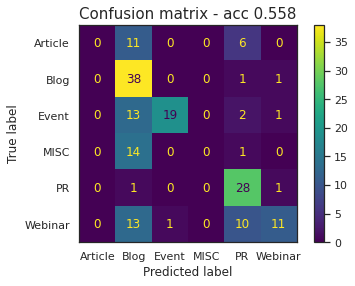


              precision    recall  f1-score   support

     Article       0.00      0.00      0.00        17
        Blog       0.42      0.95      0.58        40
       Event       0.95      0.54      0.69        35
        MISC       0.00      0.00      0.00        15
          PR       0.58      0.93      0.72        30
     Webinar       0.79      0.31      0.45        35

    accuracy                           0.56       172
   macro avg       0.46      0.46      0.41       172
weighted avg       0.55      0.56      0.49       172



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [266]:
clf = fit_model(MultinomialNB(),
                X_train_tr, 
                y_train)

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

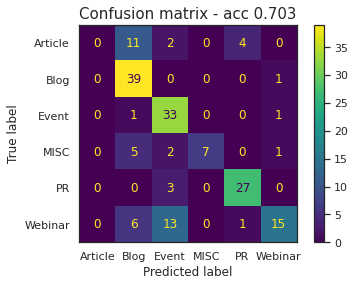


              precision    recall  f1-score   support

     Article       0.00      0.00      0.00        17
        Blog       0.63      0.97      0.76        40
       Event       0.62      0.94      0.75        35
        MISC       1.00      0.47      0.64        15
          PR       0.84      0.90      0.87        30
     Webinar       0.83      0.43      0.57        35

    accuracy                           0.70       172
   macro avg       0.65      0.62      0.60       172
weighted avg       0.68      0.70      0.65       172



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [267]:
clf = fit_model(SVC(C=1, 
                    class_weight='balanced'
                    ),
                X_train_tr, 
                y_train)

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

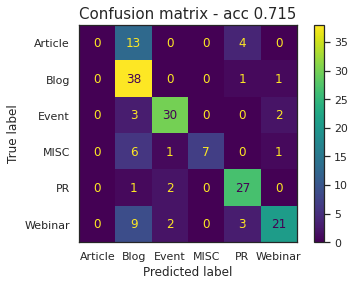


              precision    recall  f1-score   support

     Article       0.00      0.00      0.00        17
        Blog       0.54      0.95      0.69        40
       Event       0.86      0.86      0.86        35
        MISC       1.00      0.47      0.64        15
          PR       0.77      0.90      0.83        30
     Webinar       0.84      0.60      0.70        35

    accuracy                           0.72       172
   macro avg       0.67      0.63      0.62       172
weighted avg       0.69      0.72      0.68       172



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [268]:
clf = fit_model(LogisticRegression(max_iter=3000, 
                                  #  class_weight='balanced'
                                   ), 
                X_train_tr, 
                y_train)

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

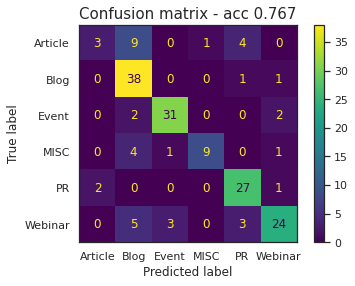


              precision    recall  f1-score   support

     Article       0.60      0.18      0.27        17
        Blog       0.66      0.95      0.78        40
       Event       0.89      0.89      0.89        35
        MISC       0.90      0.60      0.72        15
          PR       0.77      0.90      0.83        30
     Webinar       0.83      0.69      0.75        35

    accuracy                           0.77       172
   macro avg       0.77      0.70      0.71       172
weighted avg       0.77      0.77      0.75       172



In [269]:
clf = fit_model(LogisticRegression(
    max_iter=3000, 
    class_weight='balanced'
    ), 
    X_train_tr, 
    y_train,
    )

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

In [270]:
X_train_tr.toarray().shape

(685, 418869)

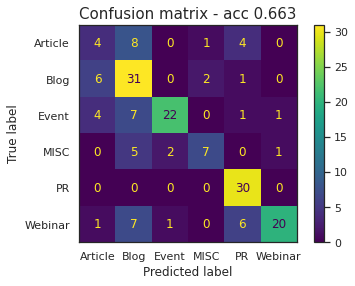


              precision    recall  f1-score   support

     Article       0.27      0.24      0.25        17
        Blog       0.53      0.78      0.63        40
       Event       0.88      0.63      0.73        35
        MISC       0.70      0.47      0.56        15
          PR       0.71      1.00      0.83        30
     Webinar       0.91      0.57      0.70        35

    accuracy                           0.66       172
   macro avg       0.67      0.61      0.62       172
weighted avg       0.70      0.66      0.66       172



In [271]:
clf = fit_model(LogisticRegression(
    max_iter=3000, 
    class_weight='balanced',
    solver='liblinear', # default: 'lbfgs' 
    penalty='l1', # default: 'l2'
    ), 
    X_train_tr, 
    y_train,
    )

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

In [272]:
print_important_features(clf, features=5)

Class "Article" - 5 most important features: ['000' 'point show nice' 'point show' 'point shot succeed' 'point shot']
Class "Blog" - 5 most important features: ['clinical' 'iqvia' '000' 'point show' 'point shot succeed']
Class "Event" - 5 most important features: ['patient' 'iqvia' '000' 'point show' 'point shot succeed']
Class "Webinar" - 5 most important features: ['000' 'point show' 'point shot succeed' 'point shot' 'point shop online']
Class "PR" - 5 most important features: ['000' 'point show nice' 'point show' 'point shot succeed' 'point shot']
Class "MISC" - 5 most important features: ['patient' 'clinical' '000' 'point show nice' 'point show']


In [273]:
misclassified_df = create_misclassified_df(X_test, y_test, y_pred)
assert (misclassified_df['y_true'] != misclassified_df['y_pred']).all()
misclassified_df

,lemmatized_cleaned_text,y_true,y_pred
292,Co produce Demy Colton EBD Group externalizati...,Event,Blog
326,Veeva MedTech Regulatory Community Meeting Thu...,Webinar,Blog
306,EUROTOX Congress 2021 dear Friends Colleagues ...,Event,Blog
138,url csscolon cascade style sheet url css funct...,Article,Blog
136,Cache web api Cache interface provide persiste...,Article,Blog
848,health system really work like system I start ...,Blog,PR
924,ObvioHealth launch clinical trial Anatara garp...,Article,PR
105,Repurposing Content develop new material conte...,Article,Blog
207,millennial really want work thing rest Us Do f...,Article,MISC
377,Gognitive Cyber artificial intelligence play i...,Event,Blog


In [274]:
INDEX = 0
true_index = misclassified_df.index[INDEX]
misclassified_df.loc[true_index, 'lemmatized_cleaned_text']

'Co produce Demy Colton EBD Group externalization team HOYA identify several partner investment participation Biotech Showcase Digital Medicine Medtech Showcase past several year diversity technology stage development offer good scouting future investment expand internal product pipeline core strategic well adjacent area EYE GI'

# 2. DistilBERT approach (Ashwin N)

### Incrementing data size to see impact on metrics

In [22]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

def extract_hidden_states(batch):
    # First convert text to tokens
    inputs = tokenizer(
        batch["text"], 
        padding=True, 
        truncation=True, 
        return_tensors='tf',
        )
    # Extract last hidden states
    outputs = tf_model(inputs)
     # Return vector for [CLS] token
    return {"hidden_state": outputs.last_hidden_state[:,0].numpy()}

In [23]:
df_text[TARGET] = df_text[TARGET].replace(labels_encoded)

In [23]:
test_size = 0.2
val_size = 0.1
random_state = 0

# Important cell # 9
column_used = 'text'
X = df_text[[column_used]]
y = df_text[TARGET]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                    test_size=1/((1-test_size)/val_size),
                                                    stratify=y_train_val, 
                                                    random_state=random_state)

In [24]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((599, 1), (86, 1), (172, 1), (599,), (86,), (172,))

In [31]:
df_text.shape[0]

857

In [25]:
test_size = 0.2
val_size = 0.1
random_state = 0

# Important cell # 9
column_used = 'text'
X = df_text[[column_used]]
y = df_text[TARGET]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                    test_size=1/((1-test_size)/val_size),
                                                    stratify=y_train_val, 
                                                    random_state=random_state)

SAMPLES_REDUCED = 50

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tf_model = TFAutoModel.from_pretrained(model_ckpt)

accs = dict()
models = list()

for i in range(16):

  train_reduced = int(SAMPLES_REDUCED * (1 - test_size - val_size))
  val_reduced = int(SAMPLES_REDUCED * (val_size))
  test_reduced = int(SAMPLES_REDUCED * (test_size))

  X_train = X_train.iloc[:-train_reduced, :]
  X_val = X_val.iloc[:-val_reduced, :]
  X_test = X_test.iloc[:-test_reduced, :]
  y_train = y_train.iloc[:-train_reduced]
  y_val = y_val.iloc[:-val_reduced]
  y_test = y_test.iloc[:-test_reduced]

  total_samples = len(X_train) + len(X_val) + len(X_test)

  dataset = DatasetDict(
      {
      'train': Dataset.from_dict(
          {'text': X_train[column_used],
          'label': y_train,
          }
          ),
      'validation': Dataset.from_dict(
          {'text': X_val[column_used],
          'label': y_val,
          }
          ),
      'test': Dataset.from_dict(
          {'text': X_test[column_used],
          'label': y_test,
          }
          ),
      }
      )

  dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  dataset_encoded.reset_format()

  dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True, batch_size=16)

  X_train_ = np.array(dataset_hidden['train']['hidden_state'])
  X_valid_ = np.array(dataset_hidden['validation']['hidden_state'])

  y_train_ = np.array(dataset_hidden['train']['label'])
  y_valid_ = np.array(dataset_hidden['validation']['label'])

  X_test_ = np.array(dataset_hidden['test']['hidden_state'])
  y_test_ = np.array(dataset_hidden['test']['label'])


  X_train_valid_ = np.concatenate([X_train_, X_valid_])
  y_train_valid_ = np.concatenate([y_train_, y_valid_])

  lr_clf = LogisticRegression(max_iter=3000)
  lr_clf.fit(X_train_valid_, y_train_valid_)
  acc = lr_clf.score(X_test_, y_test_)
  print(f'Accuracy of the {i + 1} model with {total_samples} samples: {acc:.4f}')

  accs[total_samples] = acc
  models.append(lr_clf)

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/36 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

Accuracy of the 1 model with 807 samples: 0.7840


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/34 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

Accuracy of the 2 model with 757 samples: 0.8026


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/31 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

Accuracy of the 3 model with 707 samples: 0.8169


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/29 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

Accuracy of the 4 model with 657 samples: 0.8106


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/27 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

Accuracy of the 5 model with 607 samples: 0.7787


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

Accuracy of the 6 model with 557 samples: 0.7679


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/23 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

Accuracy of the 7 model with 507 samples: 0.7451


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Accuracy of the 8 model with 457 samples: 0.7500


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/18 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Accuracy of the 9 model with 407 samples: 0.7317


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Accuracy of the 10 model with 357 samples: 0.7083


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Accuracy of the 11 model with 307 samples: 0.6774


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Accuracy of the 12 model with 257 samples: 0.6538


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

Accuracy of the 13 model with 207 samples: 0.5714


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Accuracy of the 14 model with 157 samples: 0.5625


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Accuracy of the 15 model with 107 samples: 0.4545


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Accuracy of the 16 model with 57 samples: 0.3333


In [260]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((592, 1), (85, 1), (170, 1), (598,), (79,), (170,))

In [26]:
accs

{807: 0.7839506172839507,
 757: 0.8026315789473685,
 707: 0.8169014084507042,
 657: 0.8106060606060606,
 607: 0.7786885245901639,
 557: 0.7678571428571429,
 507: 0.7450980392156863,
 457: 0.75,
 407: 0.7317073170731707,
 357: 0.7083333333333334,
 307: 0.6774193548387096,
 257: 0.6538461538461539,
 207: 0.5714285714285714,
 157: 0.5625,
 107: 0.45454545454545453,
 57: 0.3333333333333333}

In [29]:
accs = {807: 0.7839506172839507,
 757: 0.8026315789473685,
 707: 0.8169014084507042,
 657: 0.8106060606060606,
 607: 0.7786885245901639,
 557: 0.7678571428571429,
 507: 0.7450980392156863,
 457: 0.75,
 407: 0.7317073170731707,
 357: 0.7083333333333334,
 307: 0.6774193548387096,
 257: 0.6538461538461539,
 207: 0.5714285714285714,
 157: 0.5625,
 107: 0.45454545454545453,
 57: 0.3333333333333333}

In [30]:
accs

{807: 0.7839506172839507,
 757: 0.8026315789473685,
 707: 0.8169014084507042,
 657: 0.8106060606060606,
 607: 0.7786885245901639,
 557: 0.7678571428571429,
 507: 0.7450980392156863,
 457: 0.75,
 407: 0.7317073170731707,
 357: 0.7083333333333334,
 307: 0.6774193548387096,
 257: 0.6538461538461539,
 207: 0.5714285714285714,
 157: 0.5625,
 107: 0.45454545454545453,
 57: 0.3333333333333333}

And with the full dataset:

In [31]:
column_used = 'text'
X = df_text[[column_used]]
y = df_text[TARGET]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                    test_size=1/((1-test_size)/val_size),
                                                    stratify=y_train_val, 
                                                    random_state=random_state)

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tf_model = TFAutoModel.from_pretrained(model_ckpt)

total_samples = len(X_train) + len(X_val) + len(X_test)

dataset = DatasetDict(
    {
    'train': Dataset.from_dict(
        {'text': X_train[column_used],
        'label': y_train,
        }
        ),
    'validation': Dataset.from_dict(
        {'text': X_val[column_used],
        'label': y_val,
        }
        ),
    'test': Dataset.from_dict(
        {'text': X_test[column_used],
        'label': y_test,
        }
        ),
    }
    )

dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

dataset_encoded.reset_format()

dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True, batch_size=16)

X_train_ = np.array(dataset_hidden['train']['hidden_state'])
X_valid_ = np.array(dataset_hidden['validation']['hidden_state'])

y_train_ = np.array(dataset_hidden['train']['label'])
y_valid_ = np.array(dataset_hidden['validation']['label'])

X_test_ = np.array(dataset_hidden['test']['hidden_state'])
y_test_ = np.array(dataset_hidden['test']['label'])


X_train_valid_ = np.concatenate([X_train_, X_valid_])
y_train_valid_ = np.concatenate([y_train_, y_valid_])

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train_valid_, y_train_valid_)
acc = lr_clf.score(X_test_, y_test_)
print(f'Accuracy of the model with {total_samples} samples: {acc:.4f}')

accs[total_samples] = acc

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/38 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

Accuracy of the model with 857 samples: 0.8023


In [32]:
accs

{807: 0.7839506172839507,
 757: 0.8026315789473685,
 707: 0.8169014084507042,
 657: 0.8106060606060606,
 607: 0.7786885245901639,
 557: 0.7678571428571429,
 507: 0.7450980392156863,
 457: 0.75,
 407: 0.7317073170731707,
 357: 0.7083333333333334,
 307: 0.6774193548387096,
 257: 0.6538461538461539,
 207: 0.5714285714285714,
 157: 0.5625,
 107: 0.45454545454545453,
 57: 0.3333333333333333,
 857: 0.8023255813953488}

In [33]:
accs = {857: 0.8023255813953488,
 807: 0.7839506172839507,
 757: 0.8026315789473685,
 707: 0.8169014084507042,
 657: 0.8106060606060606,
 607: 0.7786885245901639,
 557: 0.7678571428571429,
 507: 0.7450980392156863,
 457: 0.75,
 407: 0.7317073170731707,
 357: 0.7083333333333334,
 307: 0.6774193548387096,
 257: 0.6538461538461539,
 207: 0.5714285714285714,
 157: 0.5625,
 107: 0.45454545454545453,
 57: 0.3333333333333333}

In [52]:
save_variable(accs, 'accuracy_samples_relation')

In [49]:
values = list(accs.values())[::-1]
samples = list(accs.keys())[::-1]

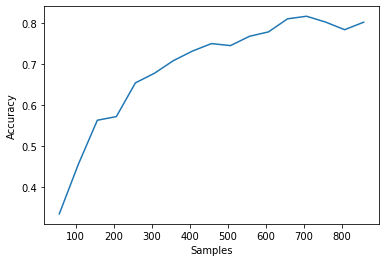

In [51]:
plt.plot(samples, values)
plt.xlabel('Samples')
plt.ylabel('Accuracy')
plt.show()

### Preprocessing

In [51]:
df_text[TARGET] = df_text[TARGET].replace(labels_encoded)

In [243]:
test_size = 0.2
val_size = 0.1
random_state = 0

# Important cell # 9
column_used = 'text'
X = df_text[[column_used]]
y = df_text[TARGET]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                    test_size=1/((1-test_size)/val_size),
                                                    stratify=y_train_val, 
                                                    random_state=random_state)


In [244]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((599, 1), (86, 1), (172, 1), (599,), (86,), (172,))

In [53]:
# Making sure the split was stratified correctly.
train_distribution = y_train.value_counts(normalize=True)
val_distribution = y_val.value_counts(normalize=True)
test_distribution = y_test.value_counts(normalize=True)
assert (np.isclose(train_distribution, val_distribution, rtol=1e-01)).all()
assert (np.isclose(train_distribution, test_distribution, rtol=1e-01)).all()

In [80]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset

dataset = DatasetDict(
    {
    'train': Dataset.from_dict(
        {'text': X_train[column_used],
         'label': y_train,
         }
         ),
    'validation': Dataset.from_dict(
        {'text': X_val[column_used],
         'label': y_val,
         }
         ),
    'test': Dataset.from_dict(
        {'text': X_test[column_used],
         'label': y_test,
         }
         ),
    }
    )

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 599
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 86
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 172
    })
})

In [81]:
train_ds = dataset['train']

In [82]:
print(train_ds[:5])

{'text': ['5 Content Strategies for Boring Brands. “If people aren’t talking about you, they’re not talking about you for a reason. And the reason isn’t that they dislike you. They’re not talking about you because you’re boring.” ~ Seth Godin  The formidable challenge for marketers of boring brands is that you have to present content that is remarkable and interesting even when your product—on the face of it—is not.  So, how should you get people to take interest in a boring brand?  The key is in distinctive presentation. Every brand has a unique story about its origin, its people and its experience. The solution is to find an authentic theme, apply creative imagination and tell your story in a way that will attract and retain people’s attention. What was widely perceived to be boring could become inspiring or at least interesting to a group of people.  Let’s face it. Boring products solve legitimate problems too. QuickBooks, toilet paper and dentures fulfill a need just as much as, if

In [83]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [84]:
text = "Tokenizing text is a core task of NLP 2021. See you on 31/12/2022."
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 25682, 1012, 2156, 2017, 2006, 2861, 1013, 2260, 1013, 16798, 2475, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [85]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '2021', '.', 'see', 'you', 'on', '31', '/', '12', '/', '202', '##2', '.', '[SEP]']


In [86]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp 2021. see you on 31 / 12 / 2022. [SEP]


In [87]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [88]:
print(tokenize(dataset["train"][:2])) 

{'input_ids': [[101, 1019, 4180, 9942, 2005, 11771, 9639, 1012, 1523, 2065, 2111, 4995, 1521, 1056, 3331, 2055, 2017, 1010, 2027, 1521, 2128, 2025, 3331, 2055, 2017, 2005, 1037, 3114, 1012, 1998, 1996, 3114, 3475, 1521, 1056, 2008, 2027, 18959, 2017, 1012, 2027, 1521, 2128, 2025, 3331, 2055, 2017, 2138, 2017, 1521, 2128, 11771, 1012, 1524, 1066, 6662, 2643, 2378, 1996, 18085, 4119, 2005, 3006, 2545, 1997, 11771, 9639, 2003, 2008, 2017, 2031, 2000, 2556, 4180, 2008, 2003, 9487, 1998, 5875, 2130, 2043, 2115, 4031, 1517, 2006, 1996, 2227, 1997, 2009, 1517, 2003, 2025, 1012, 2061, 1010, 2129, 2323, 2017, 2131, 2111, 2000, 2202, 3037, 1999, 1037, 11771, 4435, 1029, 1996, 3145, 2003, 1999, 8200, 8312, 1012, 2296, 4435, 2038, 1037, 4310, 2466, 2055, 2049, 4761, 1010, 2049, 2111, 1998, 2049, 3325, 1012, 1996, 5576, 2003, 2000, 2424, 2019, 14469, 4323, 1010, 6611, 5541, 9647, 1998, 2425, 2115, 2466, 1999, 1037, 2126, 2008, 2097, 9958, 1998, 9279, 2111, 1521, 1055, 3086, 1012, 2054, 2001, 4235, 

In [89]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [90]:
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 599
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 86
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 172
    })
})

In [91]:
tf_model = TFAutoModel.from_pretrained(model_ckpt)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [92]:
text = "this is a test"
inputs = tokenizer(text, return_tensors='tf')
inputs

{'input_ids': <tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[ 101, 2023, 2003, 1037, 3231,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [93]:
outputs = tf_model(inputs)
outputs

TFBaseModelOutput(last_hidden_state=<tf.Tensor: shape=(1, 6, 768), dtype=float32, numpy=
array([[[-0.15651304, -0.18619652,  0.0527766 , ..., -0.11881151,
          0.06620612,  0.54701567],
        [-0.35751358, -0.6483556 , -0.06178969, ..., -0.30401963,
          0.35076863,  0.5220685 ],
        [-0.27718437, -0.4459444 ,  0.18184267, ..., -0.09477945,
         -0.0075747 ,  0.9958283 ],
        [-0.2840854 , -0.39167666,  0.37525564, ..., -0.21505743,
         -0.1172516 ,  1.0526477 ],
        [ 0.26608238, -0.50936407, -0.31801325, ..., -0.42029822,
          0.01444231, -0.21489474],
        [ 0.9440614 ,  0.01117298, -0.47139406, ...,  0.14394695,
         -0.72878385, -0.16194941]]], dtype=float32)>, hidden_states=None, attentions=None)

In [94]:
outputs.last_hidden_state.shape

TensorShape([1, 6, 768])

In [95]:
dataset_encoded.reset_format()

def extract_hidden_states(batch):
    # First convert text to tokens
    inputs = tokenizer(
        batch["text"], 
        padding=True, 
        truncation=True, 
        return_tensors='tf',
        )
    # Extract last hidden states
    outputs = tf_model(inputs)
     # Return vector for [CLS] token
    return {"hidden_state": outputs.last_hidden_state[:,0].numpy()}

In [96]:
dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True, batch_size=16)
dataset_hidden

  0%|          | 0/38 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 599
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 86
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 172
    })
})

In [97]:
X_train_ = np.array(dataset_hidden['train']['hidden_state'])
X_valid_ = np.array(dataset_hidden['validation']['hidden_state'])

y_train_ = np.array(dataset_hidden['train']['label'])
y_valid_ = np.array(dataset_hidden['validation']['label'])

X_test_ = np.array(dataset_hidden['test']['hidden_state'])
y_test_ = np.array(dataset_hidden['test']['label'])

((599, 768), (86, 768), (599,), (86,))

In [98]:
X_train_.shape, X_valid_.shape, X_test_.shape, y_train_.shape, y_valid_.shape, y_test_.shape

((172, 768), (172,))

In [100]:
X_train_valid_ = np.concatenate([X_train_, X_valid_])
y_train_valid_ = np.concatenate([y_train_, y_valid_])

((599, 768), (86, 768), (685, 768))

In [ ]:
X_train_valid_.shape, y_train_valid_.shape

In [102]:
# X_valid_test_ = np.concatenate([X_valid_, X_test_])
# X_valid_.shape, X_test_.shape, X_valid_test_.shape

In [103]:
# y_valid_test_ = np.concatenate([y_valid_, y_test_])
# y_valid_.shape, y_test_.shape, y_valid_test_.shape

### a) Modeling - ML approach:

In [104]:
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train_valid_, y_train_valid_)
lr_clf.score(X_test_, y_test_)

0.8023255813953488

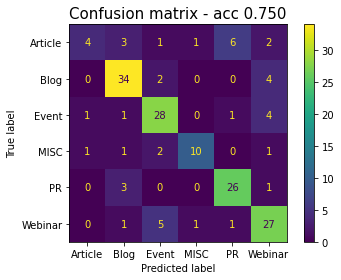


              precision    recall  f1-score   support

     Article       0.67      0.24      0.35        17
        Blog       0.79      0.85      0.82        40
       Event       0.74      0.80      0.77        35
        MISC       0.83      0.67      0.74        15
          PR       0.76      0.87      0.81        30
     Webinar       0.69      0.77      0.73        35

    accuracy                           0.75       172
   macro avg       0.75      0.70      0.70       172
weighted avg       0.75      0.75      0.74       172



In [105]:
rf_clf = fit_model(RandomForestClassifier(max_depth=10,
                                            n_estimators=50,
                                            random_state=0,
                                          ),
                X_train_valid_, 
                y_train_valid_)

y_pred = predict(rf_clf, X_test_)
y_probs = rf_clf.predict_proba(X_test_)

print_confusion_matrix(y_test_, y_pred, with_report=True)

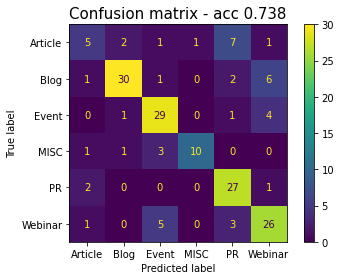


              precision    recall  f1-score   support

     Article       0.50      0.29      0.37        17
        Blog       0.88      0.75      0.81        40
       Event       0.74      0.83      0.78        35
        MISC       0.91      0.67      0.77        15
          PR       0.68      0.90      0.77        30
     Webinar       0.68      0.74      0.71        35

    accuracy                           0.74       172
   macro avg       0.73      0.70      0.70       172
weighted avg       0.74      0.74      0.73       172



In [106]:
svc_clf = fit_model(SVC(C=1, 
                    class_weight='balanced'
                    ),
                X_train_valid_, 
                y_train_valid_)

y_pred = predict(svc_clf, X_test_)

print_confusion_matrix(y_test_, y_pred, with_report=True)

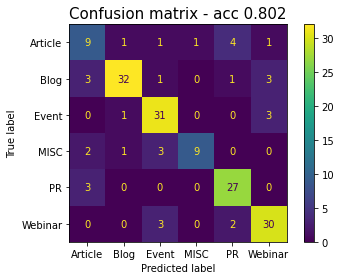


              precision    recall  f1-score   support

     Article       0.53      0.53      0.53        17
        Blog       0.91      0.80      0.85        40
       Event       0.79      0.89      0.84        35
        MISC       0.90      0.60      0.72        15
          PR       0.79      0.90      0.84        30
     Webinar       0.81      0.86      0.83        35

    accuracy                           0.80       172
   macro avg       0.79      0.76      0.77       172
weighted avg       0.81      0.80      0.80       172



In [108]:
lr_clf = fit_model(LogisticRegression(max_iter=3000, 
                                   class_weight='balanced', 
                                   ), 
                X_train_valid_, 
                y_train_valid_)

y_pred = predict(lr_clf, X_test_)
y_probs = lr_clf.predict_proba(X_test_)

print_confusion_matrix(y_test_, y_pred, with_report=True)

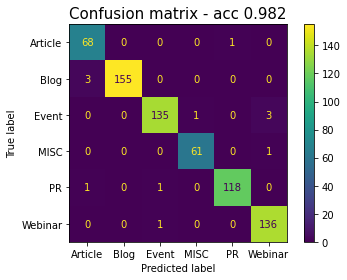


              precision    recall  f1-score   support

     Article       0.94      0.99      0.96        69
        Blog       1.00      0.98      0.99       158
       Event       0.99      0.97      0.98       139
        MISC       0.98      0.98      0.98        62
          PR       0.99      0.98      0.99       120
     Webinar       0.97      0.99      0.98       137

    accuracy                           0.98       685
   macro avg       0.98      0.98      0.98       685
weighted avg       0.98      0.98      0.98       685



In [109]:
# Check if it's overfitting
y_pred_train = predict(lr_clf, X_train_valid_)
print_confusion_matrix(y_train_valid_, y_pred_train, with_report=True)

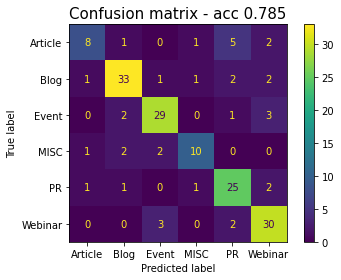


              precision    recall  f1-score   support

     Article       0.73      0.47      0.57        17
        Blog       0.85      0.82      0.84        40
       Event       0.83      0.83      0.83        35
        MISC       0.77      0.67      0.71        15
          PR       0.71      0.83      0.77        30
     Webinar       0.77      0.86      0.81        35

    accuracy                           0.78       172
   macro avg       0.78      0.75      0.75       172
weighted avg       0.79      0.78      0.78       172



In [110]:
lr_clf = fit_model(LogisticRegression(
    max_iter=3000, 
    class_weight='balanced',
    solver='liblinear', # default: 'lbfgs' 
    penalty='l1', # default: 'l2'
    ), 
    X_train_valid_, 
    y_train_valid_,
    )

y_pred = predict(lr_clf, X_test_)
y_probs = lr_clf.predict_proba(X_test_)

print_confusion_matrix(y_test_, y_pred, with_report=True)

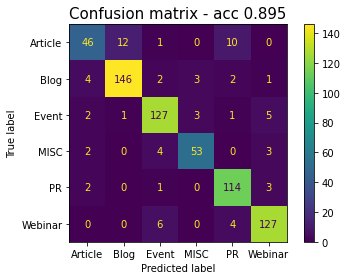


              precision    recall  f1-score   support

     Article       0.82      0.67      0.74        69
        Blog       0.92      0.92      0.92       158
       Event       0.90      0.91      0.91       139
        MISC       0.90      0.85      0.88        62
          PR       0.87      0.95      0.91       120
     Webinar       0.91      0.93      0.92       137

    accuracy                           0.89       685
   macro avg       0.89      0.87      0.88       685
weighted avg       0.89      0.89      0.89       685



In [111]:
# Check if it's overfitting
y_pred_train = predict(lr_clf, X_train_valid_)
print_confusion_matrix(y_train_valid_, y_pred_train, with_report=True)

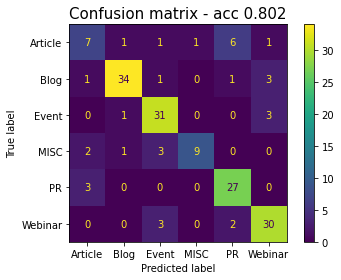


              precision    recall  f1-score   support

     Article       0.54      0.41      0.47        17
        Blog       0.92      0.85      0.88        40
       Event       0.79      0.89      0.84        35
        MISC       0.90      0.60      0.72        15
          PR       0.75      0.90      0.82        30
     Webinar       0.81      0.86      0.83        35

    accuracy                           0.80       172
   macro avg       0.79      0.75      0.76       172
weighted avg       0.80      0.80      0.80       172



In [112]:
lr_clf = fit_model(LogisticRegression(max_iter=3000, 
                                  #  class_weight='balanced', 
                                   ), 
                X_train_valid_, 
                y_train_valid_)

y_pred = predict(lr_clf, X_test_)
y_probs = lr_clf.predict_proba(X_test_)

print_confusion_matrix(y_test_, y_pred, with_report=True)

In [113]:
# lr_clf = fit_model(LogisticRegression(
#     max_iter=3000, 
#     class_weight='balanced',
#     solver='saga', # default: 'lbfgs' 
#     penalty='elasticnet', # default: 'l2',
#     l1_ratio=0.9, # only relevant when penalty='elasticnet'
#     ), 
#                 X_train_, 
#                 y_train_)

# y_pred = predict(lr_clf, X_valid_test_)
# y_probs = lr_clf.predict_proba(X_valid_test_)

# print_confusion_matrix(y_valid_test_, y_pred, with_report=True)

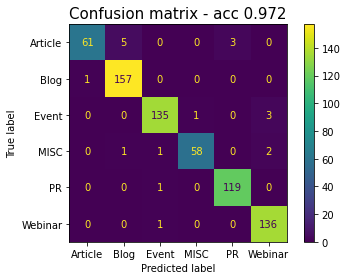


              precision    recall  f1-score   support

     Article       0.98      0.88      0.93        69
        Blog       0.96      0.99      0.98       158
       Event       0.98      0.97      0.97       139
        MISC       0.98      0.94      0.96        62
          PR       0.98      0.99      0.98       120
     Webinar       0.96      0.99      0.98       137

    accuracy                           0.97       685
   macro avg       0.97      0.96      0.97       685
weighted avg       0.97      0.97      0.97       685



In [114]:
# Check if it's overfitting
y_pred_train = predict(lr_clf, X_train_valid_)
print_confusion_matrix(y_train_valid_, y_pred_train, with_report=True)

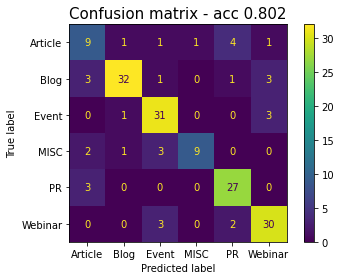


              precision    recall  f1-score   support

     Article       0.53      0.53      0.53        17
        Blog       0.91      0.80      0.85        40
       Event       0.79      0.89      0.84        35
        MISC       0.90      0.60      0.72        15
          PR       0.79      0.90      0.84        30
     Webinar       0.81      0.86      0.83        35

    accuracy                           0.80       172
   macro avg       0.79      0.76      0.77       172
weighted avg       0.81      0.80      0.80       172



In [115]:
lr_clf = fit_model(LogisticRegression(max_iter=3000, 
                                   class_weight='balanced', 
                                   ), 
                X_train_valid_, 
                y_train_valid_)

y_pred = predict(lr_clf, X_test_)
y_probs = lr_clf.predict_proba(X_test_)

print_confusion_matrix(y_test_, y_pred, with_report=True)

In [116]:
pickle.dump(lr_clf, open('/content/drive/MyDrive/url_classification/Models/distilbert_lr_clf', 'wb'))

In [117]:
# lr_clf = pickle.load(open('/content/drive/MyDrive/url_classification/Models/distilbert_lr_clf', 'rb'))

In [118]:
df_text

,text,label,url,lemmatized_text,lemmatized_cleaned_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,2,NaN,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...
1,Write For Us. Want to Write for Us? Digital L...,5,NaN,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...
2,"Write for Us. Yes, you. We’re always looking f...",5,NaN,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...
3,FAQs for some new features available in the Be...,1,NaN,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...
4,The Best Nootropic Stack to Replace Adderall &...,0,NaN,the Best Nootropic Stack to replace Adderall &...,Best Nootropic Stack replace Adderall Ritalin ...
...,...,...,...,...,...
959,Veeva Systems Korea aims to become cloud SW le...,0,http://www.koreabiomed.com/news/articleView.ht...,Veeva Systems Korea aim to become cloud SW lea...,Veeva Systems Korea aim become cloud SW leader...
960,Digital transformation of clinical research ac...,0,http://www.outsourcing-pharma.com/Article/2021...,digital transformation of clinical research ac...,digital transformation clinical research accel...
961,Veeva Systems is a Top Stock for 2022. Veeva S...,0,http://www.entrepreneur.com/article/400416,Veeva Systems be a Top Stock for 2022 . Veeva ...,Veeva Systems Top Stock 2022 Veeva Systems VEE...
962,Medidata’s Acorn AI solution raises clinical t...,0,http://www.koreabiomed.com/news/articleView.ht...,Medidata ’s Acorn AI solution raise clinical t...,Medidata Acorn AI solution raise clinical tria...


In [119]:
labels_encoded

{'Article': 0, 'Blog': 1, 'Event': 2, 'Webinar': 3, 'PR': 4, 'MISC': 5}

In [120]:
mask = y_pred != y_test_

In [121]:
X_test = pd.DataFrame(X_test, columns=['text']) # transform into DataFrame

misclassified_df = create_misclassified_df(X_test=X_test, y_test=y_test, y_pred=y_pred)
assert (misclassified_df['y_true'] != misclassified_df['y_pred']).all()
misclassified_df.head()

,text,y_true,y_pred
932,"IQVIA (IQV) Buys Remaining Q2 Solutions Stake,...",PR,Article
713,CVS inks a deal with Medable to enroll more pa...,Article,Webinar
680,California ends Verily COVID-19 testing partne...,Article,PR
84,"How to Use Hashtags: How Many, Best Ones, and ...",Blog,Article
791,Overview of EMA's latest IDMP Updates in 2022....,Blog,Webinar


In [122]:
# X_valid_test = np.concatenate([X_val, X_test]) # concatenate
# X_valid_test = pd.DataFrame(X_valid_test, columns=['text']) # transform into DataFrame

# misclassified_df = create_misclassified_df(X_test=X_valid_test, y_test=y_valid_test_, y_pred=y_pred)
# assert (misclassified_df['y_true'] != misclassified_df['y_pred']).all()
# misclassified_df

In [123]:
misclassified_df.shape

(34, 3)

In [124]:
df_merged = pd.merge(misclassified_df, df_text[['url', 'text']], on='text')
df_merged.index = misclassified_df.index
df_merged

,text,y_true,y_pred,url
932,"IQVIA (IQV) Buys Remaining Q2 Solutions Stake,...",PR,Article,http://www.zacks.com/stock/news/1348735/iqvia-...
713,CVS inks a deal with Medable to enroll more pa...,Article,Webinar,http://www.statnews.com/2022/02/08/cvs-medable...
680,California ends Verily COVID-19 testing partne...,Article,PR,http://www.beckershospitalreview.com/healthcar...
84,"How to Use Hashtags: How Many, Best Ones, and ...",Blog,Article,NaN
791,Overview of EMA's latest IDMP Updates in 2022....,Blog,Webinar,http://www.calyx.ai/journal/overview-ema-lates...
880,The Power of Patient-Centricity in Rare Diseas...,Blog,Webinar,http://medrio.com/resource/the-power-of-patien...
904,Introducing a Medical Perspective on Clinical ...,Blog,PR,http://www.calyx.ai/journal/a-medical-perspect...
524,New Data on the Future of CNS Clinical Trials....,Webinar,Event,http://science37.com/Company/Events/webinar-ne...
207,What Do Millennials Really Want at Work? The S...,Article,MISC,NaN
222,Fully Managed Magento Hosting — JetRails. Full...,MISC,Event,NaN


In [125]:
df_merged.shape

(34, 4)

In [126]:
df_confidences = df_merged[['y_true', 'y_pred']].applymap(lambda x: labels_encoded[x])
df_confidences.head()

,y_true,y_pred
932,4,0
713,0,3
680,0,4
84,1,0
791,1,3


In [127]:
df_confidences.shape

(34, 2)

In [128]:
mask = y_pred != y_test

In [129]:
# mask = y_pred != y_valid_test_ and y_valid_test_ != 5

In [132]:
# num_misc = (df_confidences['y_true'] == 5).sum()
# num_misc

In [133]:
confidence_pred = y_probs[mask, df_confidences['y_pred']]
confidence_pred

array([0.47852343, 0.65779459, 0.76266637, 0.52429177, 0.57569192,
       0.45889863, 0.44239946, 0.52224769, 0.83887097, 0.35747723,
       0.53192366, 0.44348663, 0.74126559, 0.74942645, 0.75143545,
       0.58862598, 0.94488167, 0.57746427, 0.63949315, 0.4560506 ,
       0.74984187, 0.81554   , 0.61604311, 0.80690224, 0.69743319,
       0.47026566, 0.45883194, 0.48844072, 0.65657218, 0.58439351,
       0.55748788, 0.64155521, 0.72504326, 0.52251202])

In [134]:
confidence_true = y_probs[mask, df_confidences['y_true']]
confidence_true

array([1.06330982e-02, 4.54263046e-03, 2.22608013e-01, 2.14130355e-01,
       3.98678983e-02, 3.44417994e-01, 1.44923409e-01, 3.26513112e-01,
       8.50907755e-03, 2.97718536e-01, 2.65714554e-01, 2.19222882e-02,
       2.58530860e-03, 1.49308210e-01, 1.86888861e-01, 4.07322569e-01,
       3.73701648e-02, 4.54404803e-02, 3.71951038e-02, 4.54936333e-01,
       5.91491198e-02, 1.79204692e-01, 2.29012076e-01, 1.09156224e-01,
       2.80255528e-01, 1.49794599e-01, 3.55854160e-01, 1.67886807e-01,
       1.83898898e-01, 3.95439028e-01, 4.18313024e-01, 2.08382098e-04,
       2.51553251e-01, 3.69709096e-01])

In [135]:
# confidence_true = y_probs[:-num_misc][mask[:-num_misc], df_confidences['y_true'][:-num_misc]]
# confidence_true = np.concatenate((confidence_true, np.zeros(num_misc)), axis=0)
# confidence_true

In [136]:
df_merged['conf_true'] = confidence_true.round(2)
df_merged['conf_pred'] = confidence_pred.round(2)

In [137]:
df_merged.tail()

,text,y_true,y_pred,url,conf_true,conf_pred
61,Artificial Intelligence Is Here - People Just ...,Blog,Article,NaN,0.40,0.58
3,FAQs for some new features available in the Be...,Blog,Article,NaN,0.42,0.56
206,How to Do Walking Meetings Right. New! HBR Le...,Article,Event,NaN,0.00,0.64
121,font-display | CSS-Tricks. The font-display pr...,MISC,Article,NaN,0.25,0.73
299,In Conduct of Decentralized Trials. In today’s...,Event,Webinar,http://app.swapcard.com/event/scdm-2021-annual...,0.37,0.52


In [138]:
df_merged = df_merged[['url', 'text', 'y_true', 'conf_true', 'y_pred', 'conf_pred']]

In [139]:
df_merged.shape

(34, 6)

In [140]:
# df = df_merged.iloc[13:, :]

In [141]:
# df.drop('text', axis=1).head(3)

In [143]:
misclassified = df_merged.shape[0]
misclassified_truncated = (df_merged[TEXT].str.split().str.len() > DISTILBERT_MAX_INPUT).sum()
print(f'Out of the {misclassified} misclassified samples, {misclassified_truncated}'
      f' ({misclassified_truncated / misclassified:.0%} of the total) were truncated.')

Out of the 34 misclassified samples, 11 (32% of the total) were truncated.


In [144]:
save_variable(df_merged, 'df_merged')

In [145]:
misclassified_urls = df_merged['url'].tolist()
misclassified_urls

['http://www.zacks.com/stock/news/1348735/iqvia-iqv-buys-remaining-q2-solutions-stake-ups-eps-view?cid=CS-ZC-FT-analyst_blog%7Ccompany_news_-_corporate_actions-1348735',
 'http://www.statnews.com/2022/02/08/cvs-medable-clinical-trials/',
 'http://www.beckershospitalreview.com/healthcare-information-technology/california-ends-verily-covid-19-testing-partnership.html',
 nan,
 'http://www.calyx.ai/journal/overview-ema-latest-idmp-updates/',
 'http://medrio.com/resource/the-power-of-patient-centricity-in-rare-disease-studies/',
 'http://www.calyx.ai/journal/a-medical-perspective-on-clinical-trial-technology/',
 'http://science37.com/Company/Events/webinar-new-data-future-cns-clinical-trials',
 nan,
 nan,
 'http://pages.questexinfo.com/glookowbnr12082021/?pk=Glooko',
 'http://www.zacks.com/stock/news/1754370/iqvia-iqv-announces-launch-of-clinical-data-analytics-suite?cid=CS-ZC-FT-analyst_blog%7Ccompany_news_-_corporate_actions-1754370',
 'http://www.calyx.ai/journal/ctms-unlocking-clinical-

In [146]:
wrong_conf_pred = np.max(y_probs[mask], axis=1)
wrong_conf_pred[:3]

array([0.47852343, 0.65779459, 0.76266637])

In [147]:
right_conf_pred = np.max(y_probs[~mask], axis=1)
right_conf_pred[:3]

array([0.91784542, 0.51219777, 0.98621136])

In [148]:
assert y_probs.shape[0] == wrong_conf_pred.shape[0] + right_conf_pred.shape[0]

In [149]:
# Comparison between using 'l1' vs 'l2' regularization (without class Article, with Home Page):
# Acc test set - 'l1': 0.812, 'l2': 0.808
# Acc train set - 'l1': 0.898, 'l2': 0.983
# Average confidence of misclassified samples - 'l1': 0.5134, 'l2': 0.6213
# Average confidence of correctly classified samples - 'l1': 0.6977, 'l2': 0.8412
# Median confidence of misclassified samples - 'l1': 0.4976, 'l2': 0.5665
# Median confidence of correctly classified samples - 'l1': 0.7224, 'l2': 0.8995

In [150]:
# Comparison between using 'l1' vs 'l2' regularization (with class Article, without Home Page):
# Acc test set - 'l1': 0.717, 'l2': 0.759
# Acc train set - 'l1': 0.886, 'l2': 0.988
# Average confidence of misclassified samples - 'l1': 0.581, 'l2': 0.600
# Average confidence of correctly classified samples - 'l1': 0.671, 'l2': 0.660
# Median confidence of misclassified samples - 'l1': 0.564, 'l2': 0.5813
# Median confidence of correctly classified samples - 'l1': 0.698, 'l2': 0.6841

In [151]:
sns.set_theme()

In [152]:
print(f'Confidence of incorrectly classified samples \t- Median: {np.median(wrong_conf_pred):.4f}, Mean: {np.mean(wrong_conf_pred):.4f}.')
print(f'Confidence of correctly classified samples \t- Median: {np.median(right_conf_pred):.4f}, Mean: {np.mean(right_conf_pred):.4f}.')

Confidence of incorrectly classified samples 	- Median: 0.5865, Mean: 0.6128.
Confidence of correctly classified samples 	- Median: 0.8802, Mean: 0.8285.


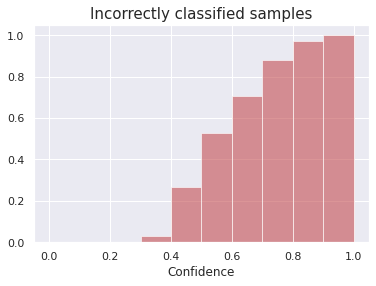

In [153]:
density=True
# plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='r', alpha=0.6)
plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='r', alpha=0.6, cumulative=1)
# plt.title('Cumulative confidence distribution in misclassified samples\n', size=14)
plt.title('Incorrectly classified samples', size=15)
plt.xlabel('Confidence')
plt.show()

In [56]:
density=True
# plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='b', alpha=0.6)
plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='g', alpha=0.6, cumulative=1)
plt.title('Cumulative confidence distribution in correctly classified samples\n', size=14)
# plt.title('Correctly classified samples', size=15)
plt.xlabel('Confidence')
plt.show()

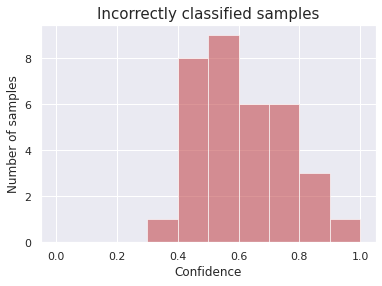

In [155]:
density=False
plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density, alpha=0.6, color='r')
# plt.title('Confidence distribution in misclassified samples\n', size=14)
plt.title('Incorrectly classified samples', size=15)
plt.xlabel('Confidence')
plt.ylabel('Number of samples')
plt.show()

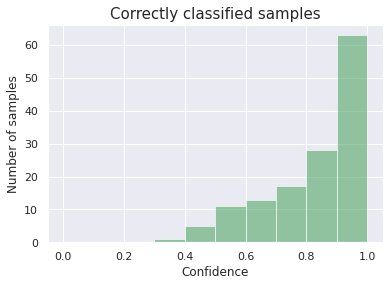

In [156]:
density=False
plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density, alpha=0.6, color='g')
# plt.title('Confidence distribution in correctly classified samples\n', size=14)
plt.title('Correctly classified samples', size=15)
plt.xlabel('Confidence')
plt.ylabel('Number of samples')
plt.show()

In [157]:
# misclassified_df = create_misclassified_df(X_test=X_valid_test, y_test=y_valid_test_, y_pred=y_pred)
# assert (misclassified_df['y_true'] != misclassified_df['y_pred']).all()
# # misclassified_df

# df_merged = pd.merge(misclassified_df, df_text[['url', 'text']], on='text')
# df_merged.index = misclassified_df.index
# # df_merged

# df_confidences = df_merged[['y_true', 'y_pred']].applymap(lambda x: labels_encoded[x])
# # df_confidences.head()

# mask = y_pred != y_valid_test_

# confidence_pred = y_probs[mask, df_confidences['y_pred']]
# # confidence_pred

# confidence_true = y_probs[mask, df_confidences['y_true']]
# # confidence_true

# df_merged['conf_true'] = confidence_true.round(2)
# df_merged['conf_pred'] = confidence_pred.round(2)
# # df_merged.head()

# df_merged = df_merged[['url', 'text', 'y_true', 'conf_true', 'y_pred', 'conf_pred']]
# # df_merged.head()

# save_variable(df_merged, 'df_merged_nn')

# misclassified_urls = df_merged['url'].tolist()
# # misclassified_urls

# wrong_conf_pred = np.max(y_probs[mask], axis=1)
# # wrong_conf_pred[:3]

# right_conf_pred = np.max(y_probs[~mask], axis=1)
# # right_conf_pred[:3]

# assert y_probs.shape[0] == wrong_conf_pred.shape[0] + right_conf_pred.shape[0]

# print(f'Average confidence of misclassified samples: {np.mean(wrong_conf_pred):.4f}')
# print(f'Average confidence of correctly classified samples: {np.mean(right_conf_pred):.4f}')

# print(f'Median confidence of misclassified samples: {np.median(wrong_conf_pred):.4f}')
# print(f'Median confidence of correctly classified samples: {np.median(right_conf_pred):.4f}')

# density=None
# plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density)
# plt.title('Distribution of confidence in misclassified samples')
# plt.show()

# plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density)
# plt.title('Distribution of confidence in correctly classified samples')
# plt.show()

### b) Modeling - DL approach:

In [182]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [183]:
tokenizer

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [184]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [185]:
# The column names to convert to TensorFlow tensors
# from transformers import DataCollatorForTokenClassification
# from transformers import DefaultDataCollator

tokenizer_columns = tokenizer.model_input_names

# Define a batch size
batch_size = 16

# data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, return_tensors='tf')
# data_collator = DefaultDataCollator(return_tensors='tf')
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')

tf_train_dataset = dataset_encoded['train'].to_tf_dataset(
    columns=tokenizer_columns, 
    label_cols=['label'], 
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator
    )

tf_eval_dataset = dataset_encoded['validation'].to_tf_dataset(
    columns=tokenizer_columns, 
    label_cols=['label'], 
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator
    )

tf_train_dataset

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


<PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [186]:
tf_test_dataset = dataset_encoded["test"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["label"], 
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator
    )

In [187]:
num_labels = len(y_train.value_counts())

In [188]:
from transformers import TFDistilBertModel, DistilBertConfig

DISTILBERT_DROPOUT = 0.2
DISTILBERT_ATT_DROPOUT = 0.1
 
# Configure DistilBERT's initialization
config = DistilBertConfig(
    dropout=DISTILBERT_DROPOUT, 
    attention_dropout=DISTILBERT_ATT_DROPOUT,
    output_hidden_states=True,
    num_labels=num_labels,
    )
                          
# The bare, pre-trained DistilBERT transformer model outputting raw hidden-states 
# and without any specific head on top.
# tf_model = TFDistilBertModel.from_pretrained(
#     'distilbert-base-uncased', 
#     config=config
#     )

# # # Make tf_model layers untrainable
# for layer in tf_model.layers:
#     layer.trainable = False

In [189]:
from transformers import TFAutoModelForSequenceClassification
tf_model = (TFAutoModelForSequenceClassification.from_pretrained(
    model_ckpt, 
    config=config, 
    # num_labels=num_labels,
    )
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_38', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [190]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# With:
# DISTILBERT_DROPOUT = 0.2
# DISTILBERT_ATT_DROPOUT = 0.1

epochs = 1000
patience = 5

tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy()
    )

callback = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True
    )

history = tf_model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset, 
    epochs=epochs,
    callbacks=[callback]
    )

Epoch 1/1000
38/38 [==============================] - 48s 1s/step - loss: 1.7609 - sparse_categorical_accuracy: 0.2521 - val_loss: 1.6946 - val_sparse_categorical_accuracy: 0.4767
Epoch 2/1000
38/38 [==============================] - 37s 979ms/step - loss: 1.6179 - sparse_categorical_accuracy: 0.5893 - val_loss: 1.5302 - val_sparse_categorical_accuracy: 0.7093
Epoch 3/1000
38/38 [==============================] - 37s 980ms/step - loss: 1.4147 - sparse_categorical_accuracy: 0.6878 - val_loss: 1.3233 - val_sparse_categorical_accuracy: 0.6977
Epoch 4/1000
38/38 [==============================] - 37s 987ms/step - loss: 1.2047 - sparse_categorical_accuracy: 0.7078 - val_loss: 1.1303 - val_sparse_categorical_accuracy: 0.7093
Epoch 5/1000
38/38 [==============================] - 37s 982ms/step - loss: 1.0323 - sparse_categorical_accuracy: 0.7579 - val_loss: 0.9867 - val_sparse_categorical_accuracy: 0.7209
Epoch 6/1000
38/38 [==============================] - 38s 988ms/step - loss: 0.8964 - sp

In [175]:
# tf.keras.models.save_model(
#     tf_model, 
#     filepath='/content/drive/MyDrive/url_classification/my_model_val0.84_test0.89', 
#     overwrite=True, 
#     save_format='tf'
#     )

In [ ]:
tf_model.save('/content/drive/MyDrive/Brew/my_model_val0.87_test0.8')

In [ ]:
# ! pwd

/content/drive/.shortcut-targets-by-id/1vLy-uUgLo6ivB3DawGntodciS6HG1L58/url_classification


In [176]:
# tf.saved_model.save(tf_model, '/content/drive/MyDrive/Brew/my_model_delete')

In [ ]:
from tensorflow.keras.models import load_model
tf_model2 = load_model(filepath='/content/drive/MyDrive/Brew/my_model_delete') 

In [ ]:
tf_model2 = tf.saved_model.load('/content/drive/MyDrive/Brew/my_model_delete')

In [188]:
tf.keras.models.save_model(tf_model, '/content/drive/MyDrive/url_classification/my_model_val0.81_test0.85')

In [ ]:
tf_model

In [186]:
tf_model2 = tf.keras.models.load_model(filepath='/content/drive/MyDrive/url_classification/my_model_val0.84_test0.89') 
# # why doesn't it work when running the next cell with the loaded model?

OSError: ignored

In [ ]:
custom_objects = {"TFAutoModelForSequenceClassification": TFAutoModelForSequenceClassification}

tf_model2 = tf.keras.models.load_model('/content/drive/MyDrive/Brew/my_model_delete', custom_objects=custom_objects)

In [178]:
# loss, train_accuracy = tf_model2.evaluate(tf_train_dataset)
# print("Loss: {}\t Train Accuracy: {}".format(loss, train_accuracy))

In [191]:
loss, train_accuracy = tf_model.evaluate(tf_train_dataset)
print("Loss: {}\t Train Accuracy: {}".format(loss, train_accuracy))

38/38 [==============================] - 12s 316ms/step - loss: 0.1531 - sparse_categorical_accuracy: 0.9750
Loss: 0.15307635068893433	 Train Accuracy: 0.9749582409858704


In [192]:
loss, eval_accuracy = tf_model.evaluate(tf_eval_dataset)
print("Loss: {}\t Eval Accuracy: {}".format(loss, eval_accuracy))

6/6 [==============================] - 2s 285ms/step - loss: 0.6126 - sparse_categorical_accuracy: 0.8256
Loss: 0.6125950813293457	 Eval Accuracy: 0.8255813717842102


In [193]:
loss, test_accuracy = tf_model.evaluate(tf_test_dataset)
print("Loss: {}\t Test Accuracy: {}".format(loss, test_accuracy))

11/11 [==============================] - 4s 325ms/step - loss: 0.5771 - sparse_categorical_accuracy: 0.8372
Loss: 0.5770680904388428	 Test Accuracy: 0.8372092843055725


In [194]:
output_logits = tf_model.predict(tf_test_dataset).logits
y_pred = np.argmax(output_logits, axis=-1)

11/11 [==============================] - 5s 321ms/step


In [195]:
y_pred

array([1, 0, 1, 1, 3, 5, 4, 4, 2, 4, 1, 3, 1, 0, 3, 3, 4, 3, 2, 2, 3, 4,
       4, 5, 2, 2, 5, 3, 3, 4, 1, 2, 5, 2, 1, 1, 1, 1, 0, 1, 4, 3, 3, 2,
       1, 1, 3, 4, 3, 2, 3, 1, 4, 3, 1, 4, 3, 4, 2, 3, 5, 0, 2, 4, 3, 1,
       2, 1, 4, 2, 1, 1, 2, 2, 1, 2, 4, 1, 1, 3, 2, 2, 4, 1, 1, 4, 0, 1,
       1, 4, 5, 2, 1, 1, 4, 1, 4, 4, 3, 3, 2, 5, 0, 3, 5, 4, 1, 2, 4, 5,
       1, 4, 0, 0, 3, 2, 2, 3, 3, 0, 2, 2, 4, 2, 3, 4, 1, 2, 1, 2, 3, 3,
       4, 5, 2, 1, 2, 4, 4, 5, 3, 4, 3, 1, 3, 1, 1, 2, 2, 4, 2, 3, 3, 0,
       0, 4, 3, 3, 2, 5, 2, 5, 4, 3, 2, 1, 2, 2, 2, 3, 1, 3])

In [196]:
y_probs = tf.nn.softmax(output_logits)
y_probs[:3]

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0.08416542, 0.878566  , 0.00733409, 0.01031895, 0.00701632,
        0.01259932],
       [0.7317688 , 0.05313385, 0.0171092 , 0.01492369, 0.12416278,
        0.05890167],
       [0.08567395, 0.85064834, 0.01047275, 0.03116656, 0.0085467 ,
        0.01349174]], dtype=float32)>

In [199]:
sns.set_theme(style='white')

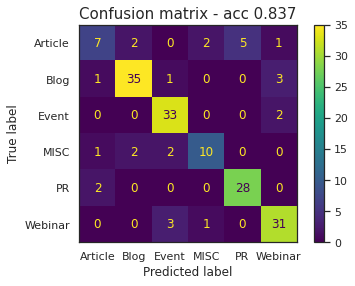


              precision    recall  f1-score   support

     Article       0.64      0.41      0.50        17
        Blog       0.90      0.88      0.89        40
       Event       0.85      0.94      0.89        35
        MISC       0.77      0.67      0.71        15
          PR       0.85      0.93      0.89        30
     Webinar       0.84      0.89      0.86        35

    accuracy                           0.84       172
   macro avg       0.81      0.79      0.79       172
weighted avg       0.83      0.84      0.83       172



In [200]:
print_confusion_matrix(y_test, y_pred, with_report=True)

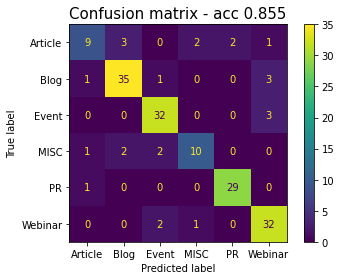


              precision    recall  f1-score   support

     Article       0.75      0.53      0.62        17
        Blog       0.88      0.88      0.88        40
       Event       0.86      0.91      0.89        35
        MISC       0.77      0.67      0.71        15
          PR       0.94      0.97      0.95        30
     Webinar       0.82      0.91      0.86        35

    accuracy                           0.85       172
   macro avg       0.84      0.81      0.82       172
weighted avg       0.85      0.85      0.85       172



In [185]:
print_confusion_matrix(y_test, y_pred, with_report=True)

In [201]:
y_pred

array([1, 0, 1, 1, 3, 5, 4, 4, 2, 4, 1, 3, 1, 0, 3, 3, 4, 3, 2, 2, 3, 4,
       4, 5, 2, 2, 5, 3, 3, 4, 1, 2, 5, 2, 1, 1, 1, 1, 0, 1, 4, 3, 3, 2,
       1, 1, 3, 4, 3, 2, 3, 1, 4, 3, 1, 4, 3, 4, 2, 3, 5, 0, 2, 4, 3, 1,
       2, 1, 4, 2, 1, 1, 2, 2, 1, 2, 4, 1, 1, 3, 2, 2, 4, 1, 1, 4, 0, 1,
       1, 4, 5, 2, 1, 1, 4, 1, 4, 4, 3, 3, 2, 5, 0, 3, 5, 4, 1, 2, 4, 5,
       1, 4, 0, 0, 3, 2, 2, 3, 3, 0, 2, 2, 4, 2, 3, 4, 1, 2, 1, 2, 3, 3,
       4, 5, 2, 1, 2, 4, 4, 5, 3, 4, 3, 1, 3, 1, 1, 2, 2, 4, 2, 3, 3, 0,
       0, 4, 3, 3, 2, 5, 2, 5, 4, 3, 2, 1, 2, 2, 2, 3, 1, 3])

In [202]:
y_test

831    1
932    4
821    1
843    1
642    3
      ..
404    2
405    2
563    3
909    1
580    3
Name: label, Length: 172, dtype: int64

In [203]:
mask = y_pred != y_test
mask

831    False
932     True
821    False
843    False
642    False
       ...  
404    False
405    False
563    False
909    False
580    False
Name: label, Length: 172, dtype: bool

In [204]:
y_pred

array([1, 0, 1, 1, 3, 5, 4, 4, 2, 4, 1, 3, 1, 0, 3, 3, 4, 3, 2, 2, 3, 4,
       4, 5, 2, 2, 5, 3, 3, 4, 1, 2, 5, 2, 1, 1, 1, 1, 0, 1, 4, 3, 3, 2,
       1, 1, 3, 4, 3, 2, 3, 1, 4, 3, 1, 4, 3, 4, 2, 3, 5, 0, 2, 4, 3, 1,
       2, 1, 4, 2, 1, 1, 2, 2, 1, 2, 4, 1, 1, 3, 2, 2, 4, 1, 1, 4, 0, 1,
       1, 4, 5, 2, 1, 1, 4, 1, 4, 4, 3, 3, 2, 5, 0, 3, 5, 4, 1, 2, 4, 5,
       1, 4, 0, 0, 3, 2, 2, 3, 3, 0, 2, 2, 4, 2, 3, 4, 1, 2, 1, 2, 3, 3,
       4, 5, 2, 1, 2, 4, 4, 5, 3, 4, 3, 1, 3, 1, 1, 2, 2, 4, 2, 3, 3, 0,
       0, 4, 3, 3, 2, 5, 2, 5, 4, 3, 2, 1, 2, 2, 2, 3, 1, 3])

In [205]:
np.array(y_test)

array([1, 4, 1, 1, 3, 0, 0, 4, 2, 4, 1, 1, 1, 0, 3, 1, 4, 3, 3, 2, 3, 4,
       4, 0, 2, 2, 5, 3, 3, 4, 1, 3, 5, 2, 1, 1, 1, 1, 4, 1, 4, 1, 3, 2,
       1, 0, 2, 0, 3, 2, 3, 1, 0, 3, 1, 4, 3, 4, 2, 3, 5, 0, 1, 4, 3, 1,
       2, 1, 4, 2, 1, 1, 2, 2, 1, 2, 4, 1, 1, 3, 2, 5, 0, 1, 1, 4, 0, 1,
       1, 4, 3, 5, 1, 0, 4, 1, 4, 4, 3, 3, 3, 5, 1, 3, 5, 4, 5, 2, 4, 5,
       1, 4, 0, 0, 3, 2, 2, 3, 3, 0, 2, 2, 0, 2, 3, 4, 1, 2, 1, 2, 3, 3,
       4, 5, 2, 5, 2, 4, 4, 5, 3, 4, 3, 1, 3, 1, 1, 2, 2, 4, 2, 3, 0, 0,
       5, 4, 3, 2, 2, 5, 2, 5, 4, 3, 2, 1, 2, 2, 2, 3, 1, 3])

In [206]:
len(y_test), len(y_pred)

(172, 172)

In [207]:
misclassified_df_nn = pd.DataFrame(
    {'y_true': y_test[mask].reset_index(drop=True).replace(labels_decoded),
     'y_pred': pd.Series(y_pred[mask]).replace(labels_decoded),
     }).set_index(y_test[mask].index)
misclassified_df_nn

,y_true,y_pred
932,PR,Article
713,Article,MISC
680,Article,PR
791,Blog,Webinar
904,Blog,Webinar
524,Webinar,Event
207,Article,MISC
538,Webinar,Event
951,PR,Article
842,Blog,Webinar


In [208]:
# I can merge with url/text using the index of y_test, do it later.

In [209]:
df_confidences_nn = misclassified_df_nn[['y_true', 'y_pred']].applymap(lambda x: labels_encoded[x])
df_confidences_nn.head()

,y_true,y_pred
932,4,0
713,0,5
680,0,4
791,1,3
904,1,3


In [210]:
y_probs_array = np.array(y_probs)

In [211]:
confidence_pred_nn = y_probs_array[mask, df_confidences_nn['y_pred']]
confidence_pred_nn

array([0.7317688 , 0.6880048 , 0.87609005, 0.8604847 , 0.9083877 ,
       0.6410547 , 0.81165284, 0.9317813 , 0.47587645, 0.9376277 ,
       0.61182654, 0.84027946, 0.8377481 , 0.8389856 , 0.851417  ,
       0.9430426 , 0.9203028 , 0.54665744, 0.9204443 , 0.8084895 ,
       0.9474942 , 0.32922313, 0.8855198 , 0.694019  , 0.7159665 ,
       0.85666305, 0.73370403, 0.9439738 ], dtype=float32)

In [212]:
confidence_true_nn = y_probs_array[mask, df_confidences_nn['y_true']]
confidence_true_nn

array([0.12416278, 0.06829616, 0.0711691 , 0.02685313, 0.02636965,
       0.26135868, 0.0567484 , 0.02559043, 0.4171192 , 0.01154234,
       0.32100692, 0.04748523, 0.11640108, 0.10977008, 0.0378789 ,
       0.01535015, 0.04170987, 0.31138265, 0.02573165, 0.14057119,
       0.0131673 , 0.25806272, 0.01883534, 0.22927858, 0.06642533,
       0.00938151, 0.05739936, 0.0123579 ], dtype=float32)

In [213]:
misclassified_df_nn['conf_true'] = confidence_true_nn.round(2)
misclassified_df_nn['conf_pred'] = confidence_pred_nn.round(2)
misclassified_df_nn.head()

,y_true,y_pred,conf_true,conf_pred
932,PR,Article,0.12,0.73
713,Article,MISC,0.07,0.69
680,Article,PR,0.07,0.88
791,Blog,Webinar,0.03,0.86
904,Blog,Webinar,0.03,0.91


In [214]:
misclassified_df_nn = misclassified_df_nn[['y_true', 'conf_true', 'y_pred', 'conf_pred']]
misclassified_df_nn

,y_true,conf_true,y_pred,conf_pred
932,PR,0.12,Article,0.73
713,Article,0.07,MISC,0.69
680,Article,0.07,PR,0.88
791,Blog,0.03,Webinar,0.86
904,Blog,0.03,Webinar,0.91
524,Webinar,0.26,Event,0.64
207,Article,0.06,MISC,0.81
538,Webinar,0.03,Event,0.93
951,PR,0.42,Article,0.48
842,Blog,0.01,Webinar,0.94


In [203]:
save_variable(misclassified_df_nn, 'df_merged_nn')

In [215]:
wrong_conf_pred = np.max(y_probs_array[mask], axis=1)
wrong_conf_pred[:3]

array([0.7317688 , 0.6880048 , 0.87609005], dtype=float32)

In [216]:
right_conf_pred = np.max(y_probs_array[~mask], axis=1)
right_conf_pred[:3]

array([0.878566  , 0.85064834, 0.9120738 ], dtype=float32)

In [217]:
assert y_probs_array.shape[0] == wrong_conf_pred.shape[0] + right_conf_pred.shape[0]

In [291]:
print(f'Confidence of incorrectly classified samples \t- Median: {np.median(wrong_conf_pred):.4f}, Mean: {np.mean(wrong_conf_pred):.4f}.')
print(f'Confidence of correctly classified samples \t- Median: {np.median(right_conf_pred):.4f}, Mean: {np.mean(right_conf_pred):.4f}.')

Confidence of incorrectly classified samples 	- Median: 0.8021, Mean: 0.7702.
Confidence of correctly classified samples 	- Median: 0.9231, Mean: 0.8750.


In [259]:
sns.set_theme()

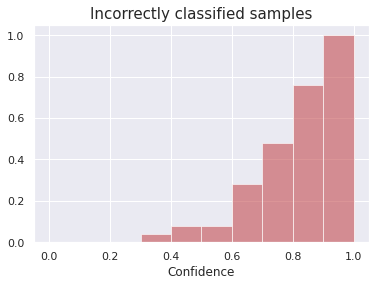

In [310]:
density=True
# plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='r', alpha=0.6)
plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='r', alpha=0.6, cumulative=1)
# plt.title('Cumulative confidence distribution in misclassified samples\n', size=14)
plt.title('Incorrectly classified samples', size=15)
plt.xlabel('Confidence')
plt.show()

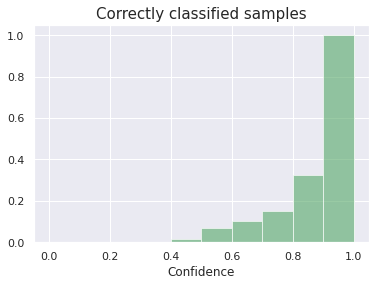

In [311]:
density=True
# plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='b', alpha=0.6)
plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='g', alpha=0.6, cumulative=1)
# plt.title('Cumulative confidence distribution in correctly classified samples\n', size=14)
plt.title('Correctly classified samples', size=15)
plt.xlabel('Confidence')
plt.show()

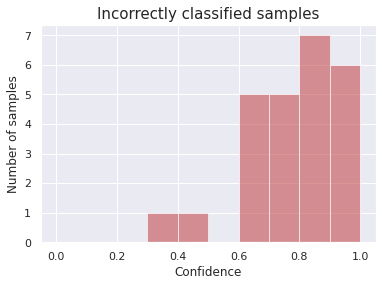

In [303]:
density=False
plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density, alpha=0.6, color='r')
# plt.title('Confidence distribution in misclassified samples\n', size=14)
plt.title('Incorrectly classified samples', size=15)
plt.xlabel('Confidence')
plt.ylabel('Number of samples')
plt.show()

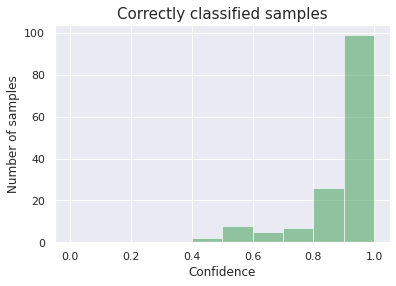

In [304]:
density=False
plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density, alpha=0.6, color='g')
# plt.title('Confidence distribution in correctly classified samples\n', size=14)
plt.title('Correctly classified samples', size=15)
plt.xlabel('Confidence')
plt.ylabel('Number of samples')
plt.show()

In [ ]:
# misclassified_df = create_misclassified_df(X_test=X_valid_test, y_test=y_test, y_pred=y_pred)
# assert (misclassified_df['y_true'] != misclassified_df['y_pred']).all()
# misclassified_df

# df_merged = pd.merge(misclassified_df, df_text[['url', 'text']], on='text')
# df_merged.index = misclassified_df.index
# # df_merged

# df_confidences = df_merged[['y_true', 'y_pred']].applymap(lambda x: labels_encoded[x])
# # df_confidences.head()

# mask = y_pred != y_valid_test_

# confidence_pred = y_probs[mask, df_confidences['y_pred']]
# # confidence_pred

# confidence_true = y_probs[mask, df_confidences['y_true']]
# # confidence_true

# df_merged['conf_true'] = confidence_true.round(2)
# df_merged['conf_pred'] = confidence_pred.round(2)
# # df_merged.head()

# df_merged = df_merged[['url', 'text', 'y_true', 'conf_true', 'y_pred', 'conf_pred']]
# # df_merged.head()

# save_variable(df_merged, 'df_merged_nn')

# misclassified_urls = df_merged['url'].tolist()
# # misclassified_urls

# wrong_conf_pred = np.max(y_probs[mask], axis=1)
# # wrong_conf_pred[:3]

# right_conf_pred = np.max(y_probs[~mask], axis=1)
# # right_conf_pred[:3]

# assert y_probs.shape[0] == wrong_conf_pred.shape[0] + right_conf_pred.shape[0]

# print(f'Average confidence of misclassified samples: {np.mean(wrong_conf_pred):.4f}')
# print(f'Average confidence of correctly classified samples: {np.mean(right_conf_pred):.4f}')

# print(f'Median confidence of misclassified samples: {np.median(wrong_conf_pred):.4f}')
# print(f'Median confidence of correctly classified samples: {np.median(right_conf_pred):.4f}')

# density=None
# plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density)
# plt.title('Distribution of confidence in misclassified samples')
# plt.show()

# plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density)
# plt.title('Distribution of confidence in correctly classified samples')
# plt.show()